# CNN
Experiments using CNN classifier to try and classify coughs as covid postive vs covid negative.

By settings random_state to some set value for both Mel Spectrogram and MFCC randomised search cross-val, we can ensure that both models have the same architecture. This allows for comparison between Mel Spectogram and MFCC for each model, whilst still enabling each model type to be compared.

## Installing Required Packages and Setting Random State

In [1]:
# standard imports
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt 
from scipy import stats
import os

# for creating representative sample of whole dataset
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import imblearn
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

# librosa and tensorflow for pre-processing and CNN
import librosa
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection

# visualisations
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
import librosa.display
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
# important definitions
parent_dir = os.path.dirname(os.getcwd())
random_state = 23

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15523557968603448048
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7105767015
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14694328876215088884
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:28:00.0, compute capability: 6.1"
]


## Sample Creation

In [4]:
# load metadata csv
metadata = pd.read_csv(f"{parent_dir}/coughvid-19/metadata_compiled.csv")

# select relevant columns for resampling later
metadata = metadata[['uuid', 'cough_detected', 'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status']]

# basic filtering
metadata = metadata[metadata['cough_detected'] >= 0.8]  # recommendation by dataset creators
metadata = metadata[metadata['status'] != 'symptomatic']  # no way of knowing whether symptomatic == covid positive or negative
metadata = metadata[metadata['status'].notna()] 
metadata.drop(columns=['cough_detected'], inplace=True) 

# fill in nulls with mean of stratum (only present in age column)
metadata["age"] = metadata.groupby(["gender", "respiratory_condition", "fever_muscle_pain"]).transform(lambda x: x.fillna(x.mean()))
# split age into bands for better stratified sampling
metadata.age = pd.cut(metadata.age, bins=10)

print("Class distribution before resampling")
print(metadata.status.value_counts())

metadata.head()

Class distribution before resampling
healthy     8300
COVID-19     699
Name: status, dtype: int64


C:\Users\danie\anaconda3\envs\ai_coursework_test\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  


,uuid,age,gender,respiratory_condition,fever_muscle_pain,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,"(10.8, 20.6]",male,False,False,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,"(30.4, 40.2]",male,True,False,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,"(20.6, 30.4]",male,False,False,healthy
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,"(20.6, 30.4]",female,False,False,healthy
11,00291cce-36a0-4a29-9e2d-c1d96ca17242,"(10.8, 20.6]",male,False,False,healthy


In [5]:
# split out positive and negative records to ensure all positive records are kept for training and testing
metadata_pos = metadata[metadata['status']=='COVID-19']
metadata_neg = metadata[metadata['status']=='healthy']

metadata_pos = metadata_pos.reset_index().drop(columns='index')
metadata_neg = metadata_neg.reset_index().drop(columns='index')

In [6]:
X_neg = metadata_neg.drop(columns=['status', 'uuid'])
y_neg = metadata_neg.status

overall_sample_size = 2500  # balance between training time, and ensuring that resampling doesn't create bias
n_positive = len(metadata_pos)

# create smaller sample of original data set
sss = StratifiedShuffleSplit(n_splits=1, test_size=(2500-n_positive)/len(y_neg), random_state=random_state)
splits = sss.split(X_neg, y_neg)
for i in splits:
    experiment_set_ind = i[1]

print(f"First 10 indeces in sample: {experiment_set_ind[:10]}\n")  # first 10 indices

negative_uuids = metadata_neg.uuid.values[experiment_set_ind]  # stratified sample of negative uuids n=2500-699
positive_uuids = metadata_pos.uuid.values 

First 10 indeces in sample: [8057 3985 5852 6820 6964 6854 2372 2792 3662 7901]



In [7]:
# select negative sample using uuids
metadata_reduced_negative = metadata[metadata['uuid'].isin(negative_uuids)]
# select positive sample using uuids
metadata_reduced_positive = metadata[metadata['uuid'].isin(positive_uuids)]

# separate out target
X_negative = metadata_reduced_negative[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_negative = metadata_reduced_negative['status']
X_positive = metadata_reduced_positive[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_positive = metadata_reduced_positive['status']

# aim to maximize number of positive cases in training data
# keep 50 in testing data
X_train_n, X_test_n , y_train_n, y_test_n = train_test_split(X_negative, y_negative, test_size=0.2495, random_state=random_state)
X_train_p, X_test_p , y_train_p, y_test_p = train_test_split(X_positive, y_positive, test_size=0.071, random_state=random_state)

X_train, y_train = pd.concat([X_train_p, X_train_n]), pd.concat([y_train_p, y_train_n])
X_test, y_test = pd.concat([X_test_p, X_test_n]), pd.concat([y_test_p, y_test_n])

print("Training set class balance BEFORE resampling:")
print(y_train.value_counts(), "\n")

print("Test set class balance BEFORE resampling:")
print(y_test.value_counts())


Training set class balance BEFORE resampling:
healthy     1351
COVID-19     649
Name: status, dtype: int64 

Test set class balance BEFORE resampling:
healthy     450
COVID-19     50
Name: status, dtype: int64


In [8]:
# balance the training set (and create balanced test set for optional use later)
# use recommended SMOTE methodology
oversample = imblearn.over_sampling.SMOTEN(sampling_strategy=1000/1351, random_state = random_state)  # desired_n/size of majority
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = random_state)
steps = [('o', oversample), ('u', undersample)]
rebalancing_pipeline = Pipeline(steps=steps)

X_train, y_train = rebalancing_pipeline.fit_resample(X_train, y_train)

print("Training set class balance AFTER resampling: ")
print(y_train.value_counts(), "\n")

Training set class balance AFTER resampling: 
COVID-19    1000
healthy     1000
Name: status, dtype: int64 



In [9]:
## create list of uuids
X_train_uuids = X_train.uuid.values
X_test_uuids = X_test.uuid.values

print(f"Re-balanced sample has {len(X_train_uuids) + len(y_test)} records from {len(negative_uuids) + len(positive_uuids)} originally.")

Re-balanced sample has 2500 records from 2500 originally.


## Load and Transform Data

In [10]:
# Load the data

PATH_TO_AUDIO = f'{parent_dir}/wav_recordings/'

def create_ds(uuid_list, audio_folder):
    """
    Returns: pandas dataframe; 
    Each dataframe has 3 columns - raw audio signal, sample rate, label (covid vs not covid)
    """
    signals = []
    labels = np.array([])
    input_len = 10*22050  # need to find justifiable length, also consider downsampling!

    for uuid in uuid_list:
        signal, _ = librosa.load(f'{audio_folder}{uuid}.wav')
        label = metadata[metadata['uuid'] == uuid]['status'].values[0]

        #signal = down_samp(signal)  # not a function (yet?)
        signal = signal[:input_len]
        zero_padding = np.zeros(input_len-len(signal))
        signal = np.append(signal, zero_padding)

        signals.append(signal)
        labels = np.append(labels, label)

    #ds = pd.DataFrame(data = data, columns=['audio', 'sample_rate', 'label'])

    return np.array(signals), labels


sample_rate = 22050.0  # checked all recordings so lets save some memory and time

train_signals, y_train = create_ds(X_train_uuids, PATH_TO_AUDIO)
test_signals, y_test = create_ds(X_test_uuids, PATH_TO_AUDIO)

In [11]:
# shuffle data (is ordered during rebalancing)
train_signals, y_train = shuffle(train_signals, y_train, random_state=random_state)
test_signals, y_test = shuffle(test_signals, y_test, random_state=random_state)

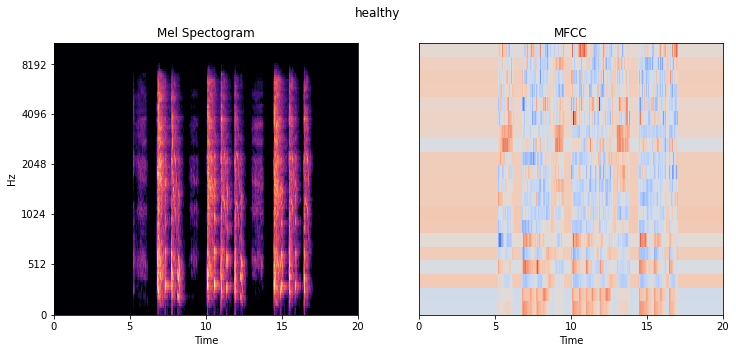

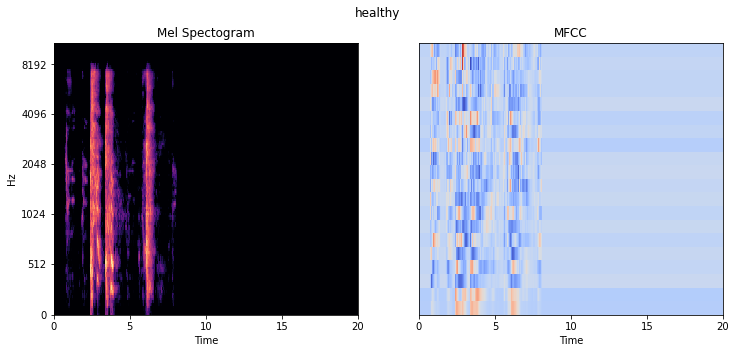

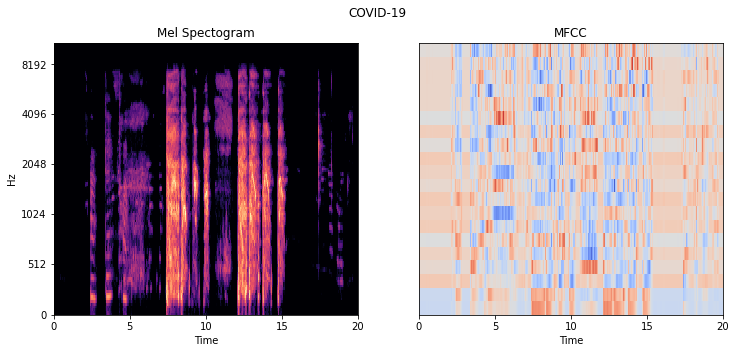

In [12]:
def get_mel_spectrogram_new(signal, n_fft=1024, n_mels = 128):
    """
    Return mel spectrogram. Adjust number of fft windows using n_fft
    """
    sgram =librosa.stft(signal, n_fft = n_fft)

    sgram_mag, _= librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, n_mels = n_mels)

    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref = np.min)

    return mel_sgram

def get_mfcc_new(signal, n_mfcc=20, n_fft = 1024, n_mels = 128):
    """
        Return mfcc with x mfccs and y n_fft
    """
    sgram =librosa.stft(signal, n_fft = n_fft)

    sgram_mag, _= librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, n_mels = n_mels)
    
    mfcc = librosa.feature.mfcc(S = mel_sgram, n_mfcc=n_mfcc)
    mfcc = preprocessing.scale(mfcc, axis=1)
    return mfcc

# plot 3 mel spectograms to show that helper function works
for a in range(3):
    i = random.randint(0, len(train_signals))
    mel_sgram = get_mel_spectrogram_new(train_signals[i])
    mfcc = get_mfcc_new(train_signals[i])


    label = y_train[i]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    librosa.display.specshow(mel_sgram, x_axis='time', y_axis='mel', ax=ax1)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax2)


    fig.suptitle(label)
    ax1.set_title('Mel Spectogram')
    ax2.set_title('MFCC')
    #plt.colorbar(format='%+2.0f dB', ax=ax1)
    plt.show()



In [13]:
train_mel_spectrograms = []
test_mel_spectrograms = []

train_mfccs = []
test_mfccs = []

for signal in train_signals:
    mel_spect = get_mel_spectrogram_new(signal)
    train_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc_new(signal)
    train_mfccs.append(mfcc)


for signal in test_signals:
    mel_spect = get_mel_spectrogram_new(signal)
    test_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc_new(signal)
    test_mfccs.append(mfcc)

train_mel_spectrograms = np.array(train_mel_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
test_mfccs = np.array(test_mfccs)

# normalise (between 0 and 1)
train_mel_spectrograms = (train_mel_spectrograms - train_mel_spectrograms.min())/(train_mel_spectrograms.max() - train_mel_spectrograms.min())
test_mel_spectrograms = (test_mel_spectrograms - test_mel_spectrograms.min())/(test_mel_spectrograms.max() - test_mel_spectrograms.min())
train_mfccs = (train_mfccs - train_mfccs.min())/(train_mfccs.max() - train_mfccs.min())
test_mfccs = (test_mfccs - test_mfccs.min())/(test_mfccs.max() - test_mfccs.min())


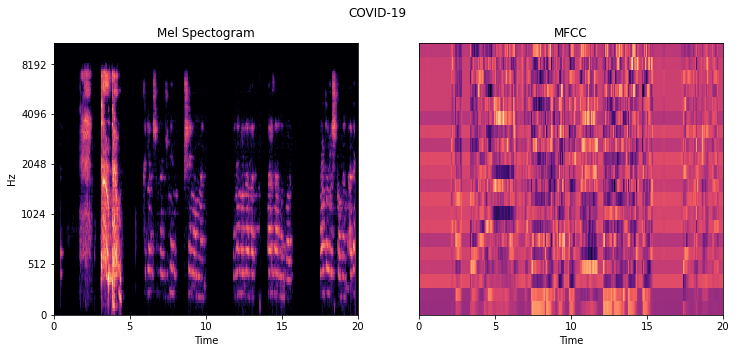

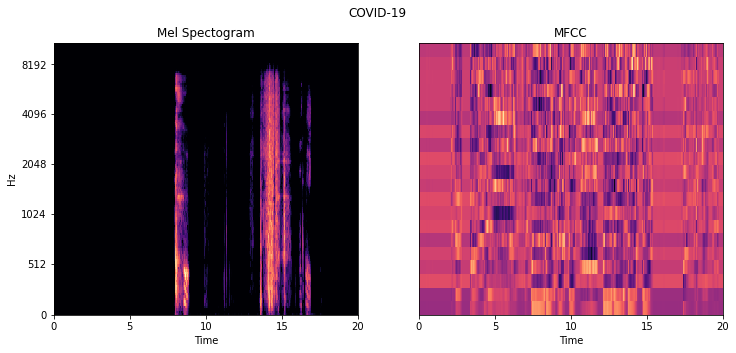

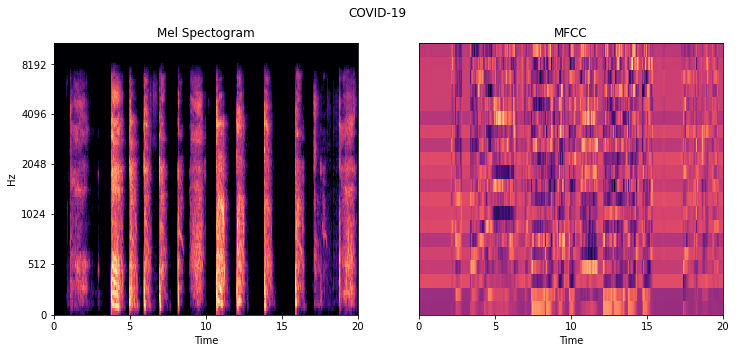

In [14]:
for a in range(3):
    i = random.randint(0, len(train_signals))
    mel_sgram = train_mel_spectrograms[i]
    mfcc = train_mfccs[i]


    label = y_train[i]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    librosa.display.specshow(mel_sgram, x_axis='time', y_axis='mel', ax=ax1)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax2)


    fig.suptitle(label)
    ax1.set_title('Mel Spectogram')
    ax2.set_title('MFCC')
    #plt.colorbar(format='%+2.0f dB', ax=ax1)
    plt.show()

In [15]:
#pre-process labels
def to_binary(label):
    if (label == 'COVID-19') or (label == 1):
        return 1
    else:
        return 0

y_train = np.array(list(map(to_binary, y_train)))
y_test = np.array(list(map(to_binary, y_test)))


In [16]:
train_mel_spectrograms = train_mel_spectrograms[...,np.newaxis]
test_mel_spectrograms = test_mel_spectrograms[..., np.newaxis]
train_mfccs = train_mfccs[...,np.newaxis]
test_mfccs = test_mfccs[..., np.newaxis]

In [17]:
train_mfccs.shape, train_mel_spectrograms.shape

((2000, 20, 862, 1), (2000, 128, 862, 1))

## Mel Spectogram 

### Defining model and training/testing data

In [18]:
X_train = train_mel_spectrograms
X_test = test_mel_spectrograms

In [19]:
def build_cnn(
    hidden_activation = 'relu',
    final_activation = 'sigmoid',
    filters = 32,
    n_conv = 1,
    n_dense = 0,
    dense_dim = 10,
    kernel_size = 3,
    dropout = False,
    dropout_p = 0.2,
    optimiser = 'Adam',
    kernel_initialiser = 'he_normal',
    learning_rate = 0.0001):
    
    model = keras.models.Sequential()

    # first layer:
    if hidden_activation == 'leaky_relu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), input_shape = (128,862,1), kernel_initializer=kernel_initialiser))
        keras.layers.LeakyReLU(alpha=0.2),
    elif hidden_activation == 'selu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='selu', padding = 'same', input_shape=(128,862,1), kernel_initializer='lecun_normal'))
    else:
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, input_shape = (128,862,1), kernel_initializer=kernel_initialiser))

    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
    
    # add regularisation (selu activation requires different dropout)
    if dropout:
        if hidden_activation == 'selu':
            model.add(keras.layers.AlphaDropout(dropout_p))
        else:
            model.add(keras.layers.Dropout(dropout_p))
    
    # add further hidden layers
    if n_conv > 1:
        for layer in range(n_conv - 1):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), padding = 'same', kernel_initializer=kernel_initialiser))
                keras.layers.LeakyReLU(alpha=0.2)
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            elif hidden_activation == 'selu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation='selu', padding = 'same', kernel_initializer='lecun_normal'))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            else:
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, padding = 'same', kernel_initializer=kernel_initialiser))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            
            if layer < 2:
                if dropout:
                    if hidden_activation == 'selu':
                        model.add(keras.layers.AlphaDropout(dropout_p))
                    else:
                        model.add(keras.layers.Dropout(dropout_p))
    
    # for any dense layers, and for output neuron
    model.add(keras.layers.Flatten())
    
    # add any dense layers
    if n_dense > 0:
        for d_layer in range(n_dense):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Dense(dense_dim))
                keras.layers.LeakyReLU(alpha=0.2)
            elif hidden_activation == 'selu':
                model.add(keras.layers.Dense(dense_dim, activation='selu', kernel_initializer='lecun_normal'))
            else:
                model.add(keras.layers.Dense(dense_dim, activation=hidden_activation, kernel_initializer=kernel_initialiser))
            
            if (layer + d_layer) < 2:
                if dropout:
                    if hidden_activation == 'selu':
                        model.add(keras.layers.AlphaDropout(dropout_p))
                    else:
                        model.add(keras.layers.Dropout(dropout_p))

    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)

    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

cnn = keras.wrappers.scikit_learn.KerasClassifier(build_cnn)

### Baseline model

In [19]:
# 3 hours + to run

param_dist= {
    'n_conv' : [2, 3, 4],
    'filters' : [16, 24, 32],
    'n_dense' : [0],
    'dense_dim' : [8, 16, 32, 64],
    'batch_size' : [16, 32],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_normal', 'lecun_normal', 'he_uniform'],
    'hidden_activation' : ['relu', 'elu', 'selu'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'optimiser' : ['momentum', 'Adam', 'Adamax'],
    'dropout' : [True, False]
}


rnd_search_cv = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 8, cv=5, scoring = ['roc_auc', 'recall'], 
                                                   refit = 'roc_auc', random_state = random_state, return_train_score = True)
rnd_search_cv.fit(X_train, y_train, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 859, 16)      272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 429, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 429, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 429, 16)       4112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 214, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 214, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 214, 16)       4

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6637 - AUC: 0.4792
Epoch 2/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6560 - AUC: 0.4713
Epoch 3/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6495 - AUC: 0.4925
Epoch 4/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6445 - AUC: 0.5086
Epoch 5/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6437 - AUC: 0.5085
Epoch 6/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6466 - AUC: 0.4976
Epoch 7/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6359 - AUC: 0.5393
Epoch 8/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6378 - AUC: 0.5284
Epoch 9/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6373 - AUC: 0.5287
Epoch 10/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6335 - AUC: 0.5459
Epoch 11/50
1600/160

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6073 - AUC: 0.6267
Epoch 28/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6097 - AUC: 0.6239
Epoch 29/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6063 - AUC: 0.6322
Epoch 30/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6133 - AUC: 0.6101
Epoch 31/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6037 - AUC: 0.6398
Epoch 32/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6067 - AUC: 0.6285
Epoch 33/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5993 - AUC: 0.6444
Epoch 34/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5988 - AUC: 0.6527
Epoch 35/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6055 - AUC: 0.6310
Epoch 36/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6019 - AUC: 0.6372
Epoch 37/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 1.0314 - AUC: 0.5159
Epoch 2/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6357 - AUC: 0.5074
Epoch 3/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6288 - AUC: 0.5556
Epoch 4/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6210 - AUC: 0.5920
Epoch 5/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5994 - AUC: 0.6564
Epoch 6/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5730 - AUC: 0.7140
Epoch 7/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5646 - AUC: 0.7149
Epoch 8/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5204 - AUC: 0.7890
Epoch 9/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4938 - AUC: 0.8178
Epoch 10/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4706 - AUC: 0.8412
Epoch 11/50
1600/160

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0702 - AUC: 0.9985
Epoch 42/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0611 - AUC: 0.9987
Epoch 43/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0558 - AUC: 0.9987
Epoch 44/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0529 - AUC: 0.9988
Epoch 45/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0474 - AUC: 0.9988
Epoch 46/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0447 - AUC: 0.9988
Epoch 47/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0421 - AUC: 0.9989
Epoch 48/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0369 - AUC: 0.9989
Epoch 49/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0365 - AUC: 0.9989
Epoch 50/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0344 - AUC: 0.9989
Model: "sequ

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7796 - AUC: 0.5072
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6384 - AUC: 0.5537
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6613 - AUC: 0.5800
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6552 - AUC: 0.5701
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6028 - AUC: 0.6373
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5949 - AUC: 0.6562
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5884 - AUC: 0.6705
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5817 - AUC: 0.6792
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5740 - AUC: 0.6909
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5543 - AUC: 0.7435
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2597 - AUC: 0.9847
Epoch 42/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2589 - AUC: 0.9828
Epoch 43/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2465 - AUC: 0.9867
Epoch 44/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2359 - AUC: 0.9896
Epoch 45/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2331 - AUC: 0.9888
Epoch 46/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2199 - AUC: 0.9919
Epoch 47/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2121 - AUC: 0.9927
Epoch 48/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2066 - AUC: 0.9938
Epoch 49/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2051 - AUC: 0.9916
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1924 - AUC: 0.9950
Model: "sequ

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7471 - AUC: 0.5103
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6111 - AUC: 0.6081
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6073 - AUC: 0.6172
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6043 - AUC: 0.6207
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5859 - AUC: 0.6667
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5686 - AUC: 0.7086
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5555 - AUC: 0.7325
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5512 - AUC: 0.7451
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5389 - AUC: 0.7603
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5503 - AUC: 0.7262
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6030 - AUC: 0.6456
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5963 - AUC: 0.6689
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5995 - AUC: 0.6561
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5945 - AUC: 0.6706
Epoch 35/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6008 - AUC: 0.6506
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5998 - AUC: 0.6553
Epoch 37/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5938 - AUC: 0.6745
Epoch 38/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5985 - AUC: 0.6587
Epoch 39/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5913 - AUC: 0.6802
Epoch 40/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5911 - AUC: 0.6752
Epoch 41/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5984 - AUC: 0.6533
Epoch 47/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5925 - AUC: 0.6695
Epoch 48/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5944 - AUC: 0.6584
Epoch 49/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5914 - AUC: 0.6734
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5959 - AUC: 0.6595
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 63, 430, 32)       9248      
___________________________

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6533 - AUC: 0.4578
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6378 - AUC: 0.4790
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6348 - AUC: 0.5046
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6302 - AUC: 0.5263
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6298 - AUC: 0.5289
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6255 - AUC: 0.5414
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6234 - AUC: 0.5516
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6214 - AUC: 0.5648
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6213 - AUC: 0.5611
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6173 - AUC: 0.5783
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 41/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 42/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 43/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 44/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 45/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 46/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 47/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 48/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Epoch 49/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 10.2829 - AUC: 0.5000
Ep

1600/1600 [==============================] - 6s 4ms/sample - loss: 4.7985 - AUC: 0.5016
Epoch 2/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9664 - AUC: 0.4996
Epoch 3/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9663 - AUC: 0.4996
Epoch 4/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9662 - AUC: 0.4996
Epoch 5/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9661 - AUC: 0.4996
Epoch 6/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9661 - AUC: 0.4996
Epoch 7/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9660 - AUC: 0.4996
Epoch 8/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9660 - AUC: 0.4996
Epoch 9/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9659 - AUC: 0.4996
Epoch 10/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 4.9659 - AUC: 0.4996
Epoch 11/50
1600/160

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7097 - AUC: 0.6151
Epoch 39/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6944 - AUC: 0.6279
Epoch 40/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7092 - AUC: 0.6225
Epoch 41/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6975 - AUC: 0.6262
Epoch 42/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7094 - AUC: 0.6308
Epoch 43/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6985 - AUC: 0.6256
Epoch 44/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7165 - AUC: 0.6084
Epoch 45/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6811 - AUC: 0.6471
Epoch 46/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6954 - AUC: 0.6440
Epoch 47/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7239 - AUC: 0.6171
Epoch 48/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.8722 - AUC: 0.4976
Epoch 2/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.8057 - AUC: 0.5089
Epoch 3/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7702 - AUC: 0.5167
Epoch 4/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7669 - AUC: 0.5273
Epoch 5/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7355 - AUC: 0.5504
Epoch 6/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7259 - AUC: 0.5619
Epoch 7/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7472 - AUC: 0.5415
Epoch 8/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6993 - AUC: 0.5878
Epoch 9/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7477 - AUC: 0.5421
Epoch 10/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7183 - AUC: 0.5741
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7170 - AUC: 0.6037
Epoch 36/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6766 - AUC: 0.6424
Epoch 37/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6746 - AUC: 0.6450
Epoch 38/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6849 - AUC: 0.6343
Epoch 39/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6714 - AUC: 0.6494
Epoch 40/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6912 - AUC: 0.6382
Epoch 41/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6954 - AUC: 0.6405
Epoch 42/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6764 - AUC: 0.6554
Epoch 43/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7046 - AUC: 0.6272
Epoch 44/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7116 - AUC: 0.6230
Epoch 45/50


1600/1600 [==============================] - 15s 9ms/sample - loss: 0.8536 - AUC: 0.5186
Epoch 2/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.9079 - AUC: 0.5138
Epoch 3/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.8790 - AUC: 0.5182
Epoch 4/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.9118 - AUC: 0.5240
Epoch 5/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.8419 - AUC: 0.4979
Epoch 6/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.8031 - AUC: 0.5151
Epoch 7/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.8412 - AUC: 0.5160
Epoch 8/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.8121 - AUC: 0.5101
Epoch 9/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.7946 - AUC: 0.5279
Epoch 10/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.8188 - AUC: 0.5067
Epoch 11/50
1600/16

1600/1600 [==============================] - 9s 5ms/sample - loss: 0.7096 - AUC: 0.5415
Epoch 28/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.7051 - AUC: 0.5425
Epoch 29/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6855 - AUC: 0.5617
Epoch 30/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.7136 - AUC: 0.5504
Epoch 31/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6833 - AUC: 0.5600
Epoch 32/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6673 - AUC: 0.5860
Epoch 33/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6939 - AUC: 0.5500
Epoch 34/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6941 - AUC: 0.5442
Epoch 35/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6807 - AUC: 0.5820
Epoch 36/50
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.6938 - AUC: 0.5627
Epoch 37/50


1600/1600 [==============================] - 10s 6ms/sample - loss: 0.6991 - AUC: 0.4998
Epoch 2/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6272 - AUC: 0.5637
Epoch 3/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6235 - AUC: 0.5808
Epoch 4/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6167 - AUC: 0.6075
Epoch 5/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6177 - AUC: 0.6080
Epoch 6/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6143 - AUC: 0.6166
Epoch 7/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6035 - AUC: 0.6480
Epoch 8/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.5946 - AUC: 0.6834
Epoch 9/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.5888 - AUC: 0.6876
Epoch 10/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.5833 - AUC: 0.6887
Epoch 11/50
1600/16

1600/1600 [==============================] - 6s 4ms/sample - loss: 0.3408 - AUC: 0.9235
Epoch 36/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.3332 - AUC: 0.9262
Epoch 37/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.3175 - AUC: 0.9375
Epoch 38/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.3108 - AUC: 0.9387
Epoch 39/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.2987 - AUC: 0.9485
Epoch 40/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.2840 - AUC: 0.9552
Epoch 41/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.2770 - AUC: 0.9583
Epoch 42/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.2650 - AUC: 0.9614
Epoch 43/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.2527 - AUC: 0.9670
Epoch 44/50
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.2399 - AUC: 0.9736
Epoch 45/50


2000/2000 [==============================] - 5s 2ms/sample - loss: 0.5978 - AUC: 0.6536


RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000183322FF808>,
                   n_iter=8,
                   param_distributions={'batch_size': [16, 32],
                                        'dense_dim': [8, 16, 32, 64],
                                        'dropout': [True, False],
                                        'filters': [16, 24, 32],
                                        'final_activation': ['sigmoid',
                                                             'hard_sigmoid'],
                                        'hidden_activation': ['relu', 'elu',
                                                              'selu'],
                                        'kernel_initialiser': ['he_normal',
                                                               'lecun_normal',
                                                               'he_uniform'],
                           

In [20]:
rnd_search_cv.best_params_

{'optimiser': 'momentum',
 'n_dense': 0,
 'n_conv': 4,
 'kernel_size': 3,
 'kernel_initialiser': 'he_normal',
 'hidden_activation': 'relu',
 'final_activation': 'hard_sigmoid',
 'filters': 32,
 'dropout': False,
 'dense_dim': 16,
 'batch_size': 16}

In [20]:
param_dist= {
    'n_conv' : [4],
    'filters' : [32],
    'n_dense' : [0],
    'dense_dim' : [16],
    'batch_size' : [16],
    'kernel_size' : [3],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['relu'],
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['momentum'],
    'dropout' : [False]
}


rnd_search_cv = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 1, cv=5, scoring = ['roc_auc', 'recall'], 
                                                   refit = 'roc_auc', random_state = random_state, return_train_score = True)
rnd_search_cv.fit(X_train, y_train, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 430, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 107, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 107, 32)       9

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6953 - AUC: 0.5215
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6870 - AUC: 0.5566
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6832 - AUC: 0.5760
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6826 - AUC: 0.5714
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6749 - AUC: 0.6119
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6682 - AUC: 0.6196
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6667 - AUC: 0.6298
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6641 - AUC: 0.6317
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6613 - AUC: 0.6403
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6591 - AUC: 0.6368
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6508 - AUC: 0.6703
Epoch 17/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6413 - AUC: 0.6730
Epoch 18/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6294 - AUC: 0.6987
Epoch 19/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6244 - AUC: 0.6979
Epoch 20/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6355 - AUC: 0.6961
Epoch 21/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6283 - AUC: 0.6910
Epoch 22/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6238 - AUC: 0.7024
Epoch 23/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6220 - AUC: 0.6992
Epoch 24/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6241 - AUC: 0.6991
Epoch 25/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6450 - AUC: 0.6651
Epoch 26/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 35/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 37/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 38/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 39/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 40/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 41/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5883 - AUC: 0.7388
Epoch 47/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5875 - AUC: 0.7389
Epoch 48/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6345 - AUC: 0.7040
Epoch 49/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5890 - AUC: 0.7461
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5854 - AUC: 0.7418
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 63, 430, 32)       9248      
____________________________

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027DE4ED5108>,
                   n_iter=1,
                   param_distributions={'batch_size': [16], 'dense_dim': [16],
                                        'dropout': [False], 'filters': [32],
                                        'final_activation': ['hard_sigmoid'],
                                        'hidden_activation': ['relu'],
                                        'kernel_initialiser': ['he_normal'],
                                        'kernel_size': [3], 'n_conv': [4],
                                        'n_dense': [0],
                                        'optimiser': ['momentum']},
                   random_state=23, refit='roc_auc', return_train_score=True,
                   scoring=['roc_auc', 'recall'])

In [21]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([191.58958545]),
 'std_fit_time': array([2.32933091]),
 'mean_score_time': array([0.96060367]),
 'std_score_time': array([0.08248951]),
 'param_optimiser': masked_array(data=['momentum'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_dense': masked_array(data=[0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_conv': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_normal'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['relu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['hard_sigmoid'],
 

Better AUC than normal but poor recall.

### Check if dense layer improves performance

In [26]:
param_grid= {
    'n_conv' : [4],
    'filters' : [32],
    'n_dense' : [1],
    'dense_dim' : [8, 16],
    'batch_size' : [16],
    'kernel_size' : [3],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['relu'],
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['momentum'],
    'dropout' : [False]
}


grid_src_1 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc',
                                         return_training_score = True)
grid_src_1.fit(X_train, y_train, epochs = 50)

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 63, 430, 32)       9248      
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 31, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 15, 107, 32)       0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 15, 107, 32)     

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6498 - AUC: 0.4409
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6444 - AUC: 0.4819
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6399 - AUC: 0.5175
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6384 - AUC: 0.5148
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6382 - AUC: 0.5180
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6401 - AUC: 0.5114
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6359 - AUC: 0.5405
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6363 - AUC: 0.5291
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6337 - AUC: 0.5493
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6316 - AUC: 0.5502
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5993 - AUC: 0.6611
Epoch 28/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6016 - AUC: 0.6512
Epoch 29/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5984 - AUC: 0.6617
Epoch 30/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5951 - AUC: 0.6649
Epoch 31/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6139 - AUC: 0.6193
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5969 - AUC: 0.6605
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5974 - AUC: 0.6669
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5917 - AUC: 0.6766
Epoch 35/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5976 - AUC: 0.6594
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5938 - AUC: 0.6713
Epoch 37/50


1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6513 - AUC: 0.4431
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6418 - AUC: 0.4922
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6398 - AUC: 0.4982
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6337 - AUC: 0.5378
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6330 - AUC: 0.5383
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6307 - AUC: 0.5548
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6281 - AUC: 0.5664
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6238 - AUC: 0.5905
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6245 - AUC: 0.5893
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6177 - AUC: 0.6088
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6206 - AUC: 0.5771
Epoch 28/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6166 - AUC: 0.6053
Epoch 29/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6184 - AUC: 0.5920
Epoch 30/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6156 - AUC: 0.6049
Epoch 31/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6182 - AUC: 0.5997
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6130 - AUC: 0.6110
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6159 - AUC: 0.6044
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6151 - AUC: 0.6028
Epoch 35/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6105 - AUC: 0.6155
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6094 - AUC: 0.6320
Epoch 37/50


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000184CF38AE48>,
             param_grid={'batch_size': [16], 'dense_dim': [8, 16],
                         'dropout': [False], 'filters': [32],
                         'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['relu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [3], 'n_conv': [4], 'n_dense': [1],
                         'optimiser': ['momentum']},
             scoring='roc_auc')

In [27]:
grid_src_1.best_params_

{'batch_size': 16,
 'dense_dim': 16,
 'dropout': False,
 'filters': 32,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'relu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 3,
 'n_conv': 4,
 'n_dense': 1,
 'optimiser': 'momentum'}

In [ ]:
grid_src_1.cv_results_

Hidden layer seemed to worsen performance during training - starting off well but then trailing off.

### Fine-tune number of convolutional layers 

In [30]:
param_grid= {
    'n_conv' : [3, 4, 5],
    'filters' : [32],
    'batch_size' : [16],
    'kernel_size' : [3],
    'dropout' : [False],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['relu'],
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['momentum'],
}


grid_src_2 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = 'roc_auc')
grid_src_2.fit(X_train, y_train, epochs = 50) 

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_201 (MaxPoolin (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 63, 430, 32)       9248      
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 31, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 15, 107, 32)       0         
_________________________________________________________________
flatten_64 (Flatten)         (None, 51360)           

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5811 - AUC: 0.6912
Epoch 22/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5814 - AUC: 0.6914
Epoch 23/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5773 - AUC: 0.6987
Epoch 24/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5784 - AUC: 0.6934
Epoch 25/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5718 - AUC: 0.7131
Epoch 26/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6052 - AUC: 0.6618
Epoch 27/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5732 - AUC: 0.7078
Epoch 28/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5688 - AUC: 0.7177
Epoch 29/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5672 - AUC: 0.7206
Epoch 30/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5644 - AUC: 0.7250
Epoch 31/50


1600/1600 [==============================] - 5s 3ms/sample - loss: 0.8081 - AUC: 0.4852
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6448 - AUC: 0.4894
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6381 - AUC: 0.5092
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6398 - AUC: 0.5264
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6288 - AUC: 0.5454
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6297 - AUC: 0.5574
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6234 - AUC: 0.5735
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6303 - AUC: 0.5635
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6221 - AUC: 0.5777
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6161 - AUC: 0.5986
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5961 - AUC: 0.6541
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5870 - AUC: 0.6855
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5866 - AUC: 0.6798
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5823 - AUC: 0.6958
Epoch 35/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5875 - AUC: 0.6703
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5809 - AUC: 0.6923
Epoch 37/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5803 - AUC: 0.6873
Epoch 38/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5848 - AUC: 0.6768
Epoch 39/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5801 - AUC: 0.6971
Epoch 40/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5797 - AUC: 0.6915
Epoch 41/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5754 - AUC: 0.6949
Epoch 47/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5722 - AUC: 0.7071
Epoch 48/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5683 - AUC: 0.7136
Epoch 49/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5690 - AUC: 0.7100
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5693 - AUC: 0.7164
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_232 (Conv2D)          (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_232 (MaxPoolin (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 63, 430, 32)       9248      
___________________________

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6551 - AUC: 0.4562
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6421 - AUC: 0.4597
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6410 - AUC: 0.4681
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6391 - AUC: 0.4753
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6379 - AUC: 0.4827
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6367 - AUC: 0.4919
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6357 - AUC: 0.4957
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6360 - AUC: 0.4966
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6349 - AUC: 0.5069
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6329 - AUC: 0.5188
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6229 - AUC: 0.5815
Epoch 26/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6200 - AUC: 0.5932
Epoch 27/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6233 - AUC: 0.5800
Epoch 28/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6184 - AUC: 0.6032
Epoch 29/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6171 - AUC: 0.6080
Epoch 30/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6184 - AUC: 0.5991
Epoch 31/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6150 - AUC: 0.6137
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6192 - AUC: 0.6015
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6142 - AUC: 0.6169
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6111 - AUC: 0.6260
Epoch 35/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6048 - AUC: 0.6315
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6048 - AUC: 0.6327
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_261 (Conv2D)          (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_261 (MaxPoolin (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_262 (Conv2D)          (None, 63, 430, 32)       9248      
_________________________________________________________________
max_pooling2d_262 (MaxPoolin (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 31, 215, 32)       9248      
_______________________________________________________________

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000184CF38AE48>,
             param_grid={'batch_size': [16], 'dropout': [False],
                         'filters': [32], 'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['relu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [3], 'n_conv': [3, 4, 5],
                         'optimiser': ['momentum']},
             scoring='roc_auc')

In [31]:
grid_src_2.best_params_

{'batch_size': 16,
 'dropout': False,
 'filters': 32,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'relu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 3,
 'n_conv': 4,
 'optimiser': 'momentum'}

In [ ]:
grid_src_2.cv_results

Higher AUC but recall still not great (is better though). Further - training AUC roughly in line with testing, points toward good generalisation.

### Fine-tuning activation function


In [34]:
param_grid= {
    'n_conv' : [4],
    'filters' : [32],
    'batch_size' : [16],
    'kernel_size' : [3],
    'dropout' : [False],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['relu', 'elu', 'selu'],
    'final_activation' : ['sigmoid', 'hard_sigmoid'],
    'optimiser' : ['momentum']
}


grid_src_3 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc',
                                         return_train_score = True)
grid_src_3.fit(X_train, y_train, epochs = 50) # from 60

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_389 (Conv2D)          (None, 126, 860, 32)      320       
_________________________________________________________________
max_pooling2d_389 (MaxPoolin (None, 63, 430, 32)       0         
_________________________________________________________________
conv2d_390 (Conv2D)          (None, 63, 430, 32)       9248      
_________________________________________________________________
max_pooling2d_390 (MaxPoolin (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_391 (Conv2D)          (None, 31, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_391 (MaxPoolin (None, 15, 107, 32)       0         
_________________________________________________________________
conv2d_392 (Conv2D)          (None, 15, 107, 32)    

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.6791 - AUC: 0.4824
Epoch 2/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6621 - AUC: 0.5021
Epoch 3/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6391 - AUC: 0.5207
Epoch 4/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6341 - AUC: 0.5481
Epoch 5/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6391 - AUC: 0.5526
Epoch 6/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6268 - AUC: 0.5775
Epoch 7/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6260 - AUC: 0.5828
Epoch 8/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6265 - AUC: 0.5835
Epoch 9/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6234 - AUC: 0.5962
Epoch 10/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6287 - AUC: 0.5731
Epoch 11/60
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6175 - AUC: 0.5908
Epoch 12/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6174 - AUC: 0.5894
Epoch 13/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6120 - AUC: 0.6218
Epoch 14/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6142 - AUC: 0.6000
Epoch 15/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6105 - AUC: 0.6153
Epoch 16/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6063 - AUC: 0.6350
Epoch 17/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6112 - AUC: 0.6145
Epoch 18/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6051 - AUC: 0.6333
Epoch 19/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6148 - AUC: 0.5963
Epoch 20/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6043 - AUC: 0.6404
Epoch 21/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6111 - AUC: 0.6091
Epoch 17/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6101 - AUC: 0.6074
Epoch 18/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6117 - AUC: 0.6040
Epoch 19/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6063 - AUC: 0.6264
Epoch 20/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6076 - AUC: 0.6120
Epoch 21/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6041 - AUC: 0.6296
Epoch 22/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6018 - AUC: 0.6422
Epoch 23/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6012 - AUC: 0.6373
Epoch 24/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5974 - AUC: 0.6511
Epoch 25/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5972 - AUC: 0.6499
Epoch 26/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5885 - AUC: 0.6674
Epoch 22/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5873 - AUC: 0.6758
Epoch 23/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5866 - AUC: 0.6741
Epoch 24/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5827 - AUC: 0.6798
Epoch 25/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5833 - AUC: 0.6798
Epoch 26/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5813 - AUC: 0.6856
Epoch 27/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5787 - AUC: 0.6925
Epoch 28/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5786 - AUC: 0.6891
Epoch 29/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5749 - AUC: 0.6962
Epoch 30/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5765 - AUC: 0.6973
Epoch 31/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5832 - AUC: 0.6934
Epoch 27/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5814 - AUC: 0.6942
Epoch 28/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5790 - AUC: 0.7042
Epoch 29/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5838 - AUC: 0.6934
Epoch 30/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5790 - AUC: 0.6978
Epoch 31/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5825 - AUC: 0.6850
Epoch 32/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5762 - AUC: 0.7104
Epoch 33/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5698 - AUC: 0.7173
Epoch 34/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5761 - AUC: 0.7026
Epoch 35/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5674 - AUC: 0.7239
Epoch 36/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5864 - AUC: 0.6822
Epoch 32/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5835 - AUC: 0.6881
Epoch 33/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5846 - AUC: 0.6846
Epoch 34/60
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5814 - AUC: 0.6906
Epoch 35/60
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5820 - AUC: 0.6887
Epoch 36/60
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5793 - AUC: 0.6968
Epoch 37/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5796 - AUC: 0.6938
Epoch 38/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5799 - AUC: 0.6925
Epoch 39/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5799 - AUC: 0.6874
Epoch 40/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5767 - AUC: 0.6997
Epoch 41/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5426 - AUC: 0.7634
Epoch 37/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5445 - AUC: 0.7549
Epoch 38/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5418 - AUC: 0.7583
Epoch 39/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5373 - AUC: 0.7665
Epoch 40/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5361 - AUC: 0.7721
Epoch 41/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5341 - AUC: 0.7719
Epoch 42/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5294 - AUC: 0.7763
Epoch 43/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5271 - AUC: 0.7860
Epoch 44/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5262 - AUC: 0.7820
Epoch 45/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5234 - AUC: 0.7887
Epoch 46/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5296 - AUC: 0.7701
Epoch 42/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5281 - AUC: 0.7723
Epoch 43/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5214 - AUC: 0.7865
Epoch 44/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5193 - AUC: 0.7870
Epoch 45/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5169 - AUC: 0.7941
Epoch 46/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5141 - AUC: 0.7901
Epoch 47/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5131 - AUC: 0.7950
Epoch 48/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5078 - AUC: 0.8056
Epoch 49/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5079 - AUC: 0.7979
Epoch 50/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5053 - AUC: 0.8050
Epoch 51/60


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5518 - AUC: 0.7387
Epoch 47/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5492 - AUC: 0.7469
Epoch 48/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5473 - AUC: 0.7463
Epoch 49/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5452 - AUC: 0.7507
Epoch 50/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5451 - AUC: 0.7507
Epoch 51/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5428 - AUC: 0.7541
Epoch 52/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5406 - AUC: 0.7572
Epoch 53/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5401 - AUC: 0.7570
Epoch 54/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5350 - AUC: 0.7612
Epoch 55/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5354 - AUC: 0.7655
Epoch 56/60


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5484 - AUC: 0.7545
Epoch 52/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5489 - AUC: 0.7507
Epoch 53/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5481 - AUC: 0.7498
Epoch 54/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5441 - AUC: 0.7587
Epoch 55/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5411 - AUC: 0.7650
Epoch 56/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5364 - AUC: 0.7726
Epoch 57/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5371 - AUC: 0.7699
Epoch 58/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5343 - AUC: 0.7716
Epoch 59/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5342 - AUC: 0.7742
Epoch 60/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5316 - AUC: 0.7794
Model: "sequ

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5415 - AUC: 0.7567
Epoch 57/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5404 - AUC: 0.7597
Epoch 58/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5373 - AUC: 0.7667
Epoch 59/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5335 - AUC: 0.7737
Epoch 60/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5336 - AUC: 0.7715
Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_441 (Conv2D)          (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_441 (MaxPoolin (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_442 (Conv2D)          (None, 64, 431, 32)       9248      
__________________________

1600/1600 [==============================] - 10s 6ms/sample - loss: 0.6647 - AUC: 0.4953
Epoch 2/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6425 - AUC: 0.5221
Epoch 3/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6309 - AUC: 0.5360
Epoch 4/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6349 - AUC: 0.5297
Epoch 5/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6123 - AUC: 0.5969
Epoch 6/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6126 - AUC: 0.6025
Epoch 7/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6059 - AUC: 0.6213
Epoch 8/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6085 - AUC: 0.6105
Epoch 9/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6033 - AUC: 0.6313
Epoch 10/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6058 - AUC: 0.6182
Epoch 11/60
1600/16

Epoch 6/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6347 - AUC: 0.5395
Epoch 7/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6267 - AUC: 0.5602
Epoch 8/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6184 - AUC: 0.5946
Epoch 9/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6180 - AUC: 0.5992
Epoch 10/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6153 - AUC: 0.6026
Epoch 11/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6135 - AUC: 0.6132
Epoch 12/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6137 - AUC: 0.6054
Epoch 13/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6090 - AUC: 0.6240
Epoch 14/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6089 - AUC: 0.6250
Epoch 15/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6104 - AUC: 0.6133
Epoc

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6360 - AUC: 0.5409
Epoch 12/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6273 - AUC: 0.5729
Epoch 13/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6260 - AUC: 0.5787
Epoch 14/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6251 - AUC: 0.5904
Epoch 15/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6327 - AUC: 0.5594
Epoch 16/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6251 - AUC: 0.5880
Epoch 17/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6230 - AUC: 0.5956
Epoch 18/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6199 - AUC: 0.6059
Epoch 19/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6200 - AUC: 0.6043
Epoch 20/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6235 - AUC: 0.5910
Epoch 21/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6165 - AUC: 0.6137
Epoch 17/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6208 - AUC: 0.5925
Epoch 18/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6131 - AUC: 0.6258
Epoch 19/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6098 - AUC: 0.6319
Epoch 20/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6120 - AUC: 0.6237
Epoch 21/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6097 - AUC: 0.6253
Epoch 22/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6121 - AUC: 0.6205
Epoch 23/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6071 - AUC: 0.6312
Epoch 24/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6092 - AUC: 0.6282
Epoch 25/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6080 - AUC: 0.6292
Epoch 26/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6029 - AUC: 0.6431
Epoch 22/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6028 - AUC: 0.6514
Epoch 23/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6021 - AUC: 0.6462
Epoch 24/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6054 - AUC: 0.6321
Epoch 25/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5999 - AUC: 0.6502
Epoch 26/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6039 - AUC: 0.6401
Epoch 27/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6034 - AUC: 0.6356
Epoch 28/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5983 - AUC: 0.6560
Epoch 29/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6045 - AUC: 0.6390
Epoch 30/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5975 - AUC: 0.6544
Epoch 31/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6068 - AUC: 0.6268
Epoch 27/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6057 - AUC: 0.6280
Epoch 28/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6017 - AUC: 0.6416
Epoch 29/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6020 - AUC: 0.6401
Epoch 30/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6039 - AUC: 0.6257
Epoch 31/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5986 - AUC: 0.6449
Epoch 32/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5974 - AUC: 0.6520
Epoch 33/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6003 - AUC: 0.6350
Epoch 34/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5981 - AUC: 0.6412
Epoch 35/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5934 - AUC: 0.6599
Epoch 36/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5793 - AUC: 0.6954
Epoch 32/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5787 - AUC: 0.6927
Epoch 33/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5799 - AUC: 0.6907
Epoch 34/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5754 - AUC: 0.7026
Epoch 35/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5769 - AUC: 0.6971
Epoch 36/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5728 - AUC: 0.7029
Epoch 37/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5776 - AUC: 0.6919
Epoch 38/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5738 - AUC: 0.7023
Epoch 39/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5700 - AUC: 0.7100
Epoch 40/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5704 - AUC: 0.7069
Epoch 41/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5632 - AUC: 0.7271
Epoch 37/60
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5630 - AUC: 0.7278
Epoch 38/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5619 - AUC: 0.7271
Epoch 39/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5618 - AUC: 0.7226
Epoch 40/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5575 - AUC: 0.7388
Epoch 41/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5540 - AUC: 0.7453
Epoch 42/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5529 - AUC: 0.7428
Epoch 43/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5543 - AUC: 0.7383
Epoch 44/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5544 - AUC: 0.7405
Epoch 45/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5454 - AUC: 0.7547
Epoch 46/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5513 - AUC: 0.7455
Epoch 42/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5488 - AUC: 0.7511
Epoch 43/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5458 - AUC: 0.7541
Epoch 44/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5418 - AUC: 0.7570
Epoch 45/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5477 - AUC: 0.7462
Epoch 46/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5415 - AUC: 0.7556
Epoch 47/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5356 - AUC: 0.7650
Epoch 48/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5376 - AUC: 0.7674
Epoch 49/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5346 - AUC: 0.7662
Epoch 50/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5303 - AUC: 0.7700
Epoch 51/60


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5634 - AUC: 0.7210
Epoch 47/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5614 - AUC: 0.7335
Epoch 48/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5626 - AUC: 0.7239
Epoch 49/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5580 - AUC: 0.7371
Epoch 50/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5588 - AUC: 0.7284
Epoch 51/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5544 - AUC: 0.7434
Epoch 52/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5558 - AUC: 0.7403
Epoch 53/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5522 - AUC: 0.7435
Epoch 54/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5540 - AUC: 0.7390
Epoch 55/60
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5483 - AUC: 0.7541
Epoch 56/60


Epoch 55/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5313 - AUC: 0.7684
Epoch 56/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5258 - AUC: 0.7721
Epoch 57/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5255 - AUC: 0.7765
Epoch 58/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5235 - AUC: 0.7776
Epoch 59/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5238 - AUC: 0.7718
Epoch 60/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5190 - AUC: 0.7818
Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_493 (Conv2D)          (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_493 (MaxPoolin (None, 64, 431, 32)       0         
______________________________________________

Epoch 60/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5346 - AUC: 0.7643
Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_497 (Conv2D)          (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_497 (MaxPoolin (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_498 (Conv2D)          (None, 64, 431, 32)       9248      
_________________________________________________________________
max_pooling2d_498 (MaxPoolin (None, 32, 215, 32)       0         
_________________________________________________________________
conv2d_499 (Conv2D)          (None, 32, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_499 (MaxPoolin (None, 16, 107, 32)       0         
__________________

1600/1600 [==============================] - 10s 6ms/sample - loss: 0.6490 - AUC: 0.5106
Epoch 2/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6455 - AUC: 0.5377
Epoch 3/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6223 - AUC: 0.5684
Epoch 4/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6238 - AUC: 0.5872
Epoch 5/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6161 - AUC: 0.5977
Epoch 6/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6135 - AUC: 0.6026
Epoch 7/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6152 - AUC: 0.5968
Epoch 8/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6132 - AUC: 0.6085
Epoch 9/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6176 - AUC: 0.5921
Epoch 10/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6067 - AUC: 0.6325
Epoch 11/60
1600/16

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6133 - AUC: 0.5975
Epoch 7/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6139 - AUC: 0.5906
Epoch 8/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6208 - AUC: 0.5731
Epoch 9/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6106 - AUC: 0.6051
Epoch 10/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6063 - AUC: 0.6232
Epoch 11/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6058 - AUC: 0.6272
Epoch 12/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6037 - AUC: 0.6311
Epoch 13/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6000 - AUC: 0.6389
Epoch 14/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6043 - AUC: 0.6273
Epoch 15/60
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6018 - AUC: 0.6363
Epoch 16/60
160

2000/2000 [==============================] - 9s 4ms/sample - loss: 0.6064 - AUC: 0.6349
Epoch 12/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.6099 - AUC: 0.6242
Epoch 13/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.6040 - AUC: 0.6389
Epoch 14/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.6020 - AUC: 0.6499
Epoch 15/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.6003 - AUC: 0.6530
Epoch 16/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.5978 - AUC: 0.6598
Epoch 17/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.5976 - AUC: 0.6563
Epoch 18/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.5992 - AUC: 0.6526
Epoch 19/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.5940 - AUC: 0.6716
Epoch 20/60
2000/2000 [==============================] - 9s 4ms/sample - loss: 0.5933 - AUC: 0.6670
Epoch 21/60


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000184CF38AE48>,
             param_grid={'batch_size': [16], 'dropout': [False],
                         'filters': [32],
                         'final_activation': ['sigmoid', 'hard_sigmoid'],
                         'hidden_activation': ['relu', 'elu', 'selu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [3], 'n_conv': [4],
                         'optimiser': ['momentum']},
             scoring='roc_auc')

In [35]:
grid_src_3.best_params_

{'batch_size': 16,
 'dropout': False,
 'filters': 32,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 3,
 'n_conv': 4,
 'optimiser': 'momentum'}

In [22]:
param_grid= {
    'n_conv' : [4],
    'filters' : [32],
    'batch_size' : [16],
    'kernel_size' : [3],
    'dropout' : [False],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['momentum']
}


grid_src_3 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc',
                                         return_train_score = True)
grid_src_3.fit(X_train, y_train, epochs = 50) # from 60

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 431, 32)       9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 215, 32)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 107, 32)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 107, 32)      

1600/1600 [==============================] - 10s 6ms/sample - loss: 0.6934 - AUC: 0.5434
Epoch 2/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6944 - AUC: 0.5526
Epoch 3/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6810 - AUC: 0.5892
Epoch 4/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6700 - AUC: 0.6182
Epoch 5/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6610 - AUC: 0.6407
Epoch 6/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6617 - AUC: 0.6353
Epoch 7/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6653 - AUC: 0.6264
Epoch 8/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6540 - AUC: 0.6468
Epoch 9/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6428 - AUC: 0.6772
Epoch 10/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6391 - AUC: 0.6806
Epoch 11/50
1600/16

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6150 - AUC: 0.7180
Epoch 17/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6117 - AUC: 0.7164
Epoch 18/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6087 - AUC: 0.7259
Epoch 19/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6032 - AUC: 0.7338
Epoch 20/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6020 - AUC: 0.7337
Epoch 21/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5939 - AUC: 0.7451
Epoch 22/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5923 - AUC: 0.7458
Epoch 23/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5876 - AUC: 0.7511
Epoch 24/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5845 - AUC: 0.7548
Epoch 25/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5800 - AUC: 0.7562
Epoch 26/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5643 - AUC: 0.7744
Epoch 32/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5624 - AUC: 0.7747
Epoch 33/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5598 - AUC: 0.7739
Epoch 34/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5571 - AUC: 0.7780
Epoch 35/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5504 - AUC: 0.7838
Epoch 36/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5475 - AUC: 0.7858
Epoch 37/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5469 - AUC: 0.7873
Epoch 38/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5422 - AUC: 0.7919
Epoch 39/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5366 - AUC: 0.7948
Epoch 40/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5354 - AUC: 0.7980
Epoch 41/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5042 - AUC: 0.8215
Epoch 47/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5048 - AUC: 0.8191
Epoch 48/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4989 - AUC: 0.8244
Epoch 49/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4989 - AUC: 0.8257
Epoch 50/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4960 - AUC: 0.8279
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 431, 32)       9248      
___________________________

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027DE4ED5108>,
             param_grid={'batch_size': [16], 'dropout': [False],
                         'filters': [32], 'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['selu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [3], 'n_conv': [4],
                         'optimiser': ['momentum']},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'recall'])

In [23]:
grid_src_3.cv_results_

{'mean_fit_time': array([355.29561806]),
 'std_fit_time': array([1.79716232]),
 'mean_score_time': array([1.58743491]),
 'std_score_time': array([0.02085457]),
 'param_batch_size': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[False],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['hard_sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_normal'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[3],
  

#### Evaluate performance

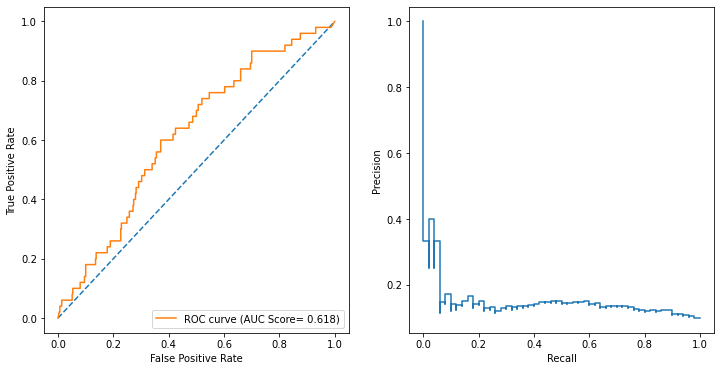

              precision    recall  f1-score   support

           0      0.918     0.720     0.807       450
           1      0.143     0.420     0.213        50

    accuracy                          0.690       500
   macro avg      0.530     0.570     0.510       500
weighted avg      0.840     0.690     0.748       500



[]

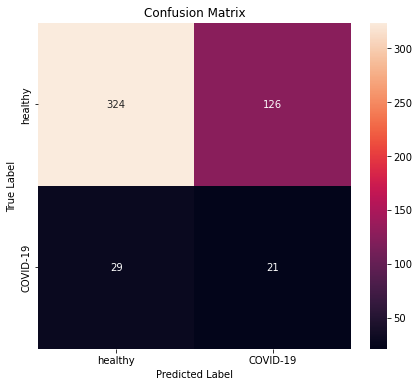

In [24]:
gs_3= grid_src_3.best_estimator_.model
y_test_pred = gs_3.predict_classes(X_test).reshape(-1)
y_test_probs = gs_3.predict_proba(X_test).reshape(-1)

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC Score= {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot() 

Training AUC is still pretty low and loss high, performance generally unchanged but marginally better recall. Hopefully better optimiser will help. Otherwise we'll have to move onto a different model. Training epochs may also be an issue.

### Fine-tuning optimiser

In [25]:
param_grid= {
    'n_conv' : [4],
    'filters' : [32],
    'batch_size' : [16],
    'kernel_size' : [3],
    'dropout' : [False],
    'hidden_activation' : ['selu'], 
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['Adamax', 'Adam']
}


grid_src_4 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc',
                                         return_train_score = True)
grid_src_4.fit(X_train, y_train, epochs = 50)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 431, 32)       9248      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 215, 32)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 107, 32)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 107, 32)     

1600/1600 [==============================] - 11s 7ms/sample - loss: 0.6960 - AUC: 0.5114
Epoch 2/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6789 - AUC: 0.5902
Epoch 3/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6731 - AUC: 0.6102
Epoch 4/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6604 - AUC: 0.6467
Epoch 5/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6499 - AUC: 0.6696
Epoch 6/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6449 - AUC: 0.6713
Epoch 7/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6375 - AUC: 0.6784
Epoch 8/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6299 - AUC: 0.6953
Epoch 9/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6239 - AUC: 0.7017
Epoch 10/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6153 - AUC: 0.7185
Epoch 11/50
1600/16

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5982 - AUC: 0.7372
Epoch 17/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5919 - AUC: 0.7470
Epoch 18/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5898 - AUC: 0.7448
Epoch 19/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5836 - AUC: 0.7509
Epoch 20/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5766 - AUC: 0.7585
Epoch 21/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5718 - AUC: 0.7638
Epoch 22/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5702 - AUC: 0.7617
Epoch 23/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5614 - AUC: 0.7710
Epoch 24/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5590 - AUC: 0.7711
Epoch 25/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5533 - AUC: 0.7779
Epoch 26/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5143 - AUC: 0.8130
Epoch 32/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5115 - AUC: 0.8132
Epoch 33/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5089 - AUC: 0.8163
Epoch 34/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5055 - AUC: 0.8199
Epoch 35/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5073 - AUC: 0.8167
Epoch 36/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5016 - AUC: 0.8194
Epoch 37/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4956 - AUC: 0.8255
Epoch 38/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4917 - AUC: 0.8289
Epoch 39/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4907 - AUC: 0.8299
Epoch 40/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4899 - AUC: 0.8331
Epoch 41/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4484 - AUC: 0.8625
Epoch 47/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4418 - AUC: 0.8672
Epoch 48/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4388 - AUC: 0.8711
Epoch 49/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4331 - AUC: 0.8751
Epoch 50/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4308 - AUC: 0.8730
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 431, 32)       9248      
___________________________

1600/1600 [==============================] - 11s 7ms/sample - loss: 0.7045 - AUC: 0.5120
Epoch 2/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6702 - AUC: 0.6131
Epoch 3/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6619 - AUC: 0.6246
Epoch 4/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6311 - AUC: 0.6986
Epoch 5/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.6131 - AUC: 0.7139
Epoch 6/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5950 - AUC: 0.7371
Epoch 7/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5831 - AUC: 0.7515
Epoch 8/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5650 - AUC: 0.7656
Epoch 9/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5413 - AUC: 0.7882
Epoch 10/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.5256 - AUC: 0.7981
Epoch 11/50
1600/16

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4186 - AUC: 0.8820
Epoch 17/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4084 - AUC: 0.8848
Epoch 18/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3871 - AUC: 0.9000
Epoch 19/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3724 - AUC: 0.9096
Epoch 20/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3623 - AUC: 0.9209
Epoch 21/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3381 - AUC: 0.9277
Epoch 22/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3280 - AUC: 0.9346
Epoch 23/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3158 - AUC: 0.9406
Epoch 24/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2902 - AUC: 0.9537
Epoch 25/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3317 - AUC: 0.9430
Epoch 26/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2489 - AUC: 0.9666
Epoch 32/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2341 - AUC: 0.9701
Epoch 33/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2270 - AUC: 0.9718
Epoch 34/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2121 - AUC: 0.9753
Epoch 35/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2092 - AUC: 0.9796
Epoch 36/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1881 - AUC: 0.9822
Epoch 37/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1737 - AUC: 0.9858
Epoch 38/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1637 - AUC: 0.9888
Epoch 39/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1549 - AUC: 0.9892
Epoch 40/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1394 - AUC: 0.9930
Epoch 41/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1385 - AUC: 0.9944
Epoch 47/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1256 - AUC: 0.9961
Epoch 48/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1160 - AUC: 0.9964
Epoch 49/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.1091 - AUC: 0.9970
Epoch 50/50
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.0973 - AUC: 0.9978
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 64, 431, 32)       9248      
___________________________

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027DE4ED5108>,
             param_grid={'batch_size': [16], 'dropout': [False],
                         'filters': [32], 'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['selu'], 'kernel_size': [3],
                         'n_conv': [4], 'optimiser': ['Adamax', 'Adam']},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'recall'])

In [26]:
grid_src_4.best_params_

{'batch_size': 16,
 'dropout': False,
 'filters': 32,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'selu',
 'kernel_size': 3,
 'n_conv': 4,
 'optimiser': 'Adamax'}

In [27]:
grid_src_4.cv_results_

{'mean_fit_time': array([356.91486354, 355.67430544]),
 'std_fit_time': array([1.31657656, 1.3600897 ]),
 'mean_score_time': array([1.6018218 , 1.60036316]),
 'std_score_time': array([0.01995021, 0.0137032 ]),
 'param_batch_size': masked_array(data=[16, 16],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[False, False],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[32, 32],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['hard_sigmoid', 'hard_sigmoid'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu', 'selu'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[3, 3],
              mas

Looks like it may be overfitting.

### Fine-tuning optimiser with regularisation

In [28]:
param_grid= {
    'n_conv' : [4],
    'filters' : [32],
    'batch_size' : [16],
    'kernel_size' : [3],
    'dropout' : [True],
    'hidden_activation' : ['selu'], 
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['Adamax']
}


grid_src_5 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc',
                                         return_train_score = True)
grid_src_5.fit(X_train, y_train, epochs = 50) 

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 128, 862, 32)      320       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 64, 431, 32)       0         
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 64, 431, 32)       0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 64, 431, 32)       9248      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 32, 215, 32)       0         
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 32, 215, 32)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 215, 32)     

1600/1600 [==============================] - 11s 7ms/sample - loss: 1.1048 - AUC: 0.5208
Epoch 2/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0242 - AUC: 0.4811
Epoch 3/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0646 - AUC: 0.4863
Epoch 4/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0997 - AUC: 0.4794
Epoch 5/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1264 - AUC: 0.5139
Epoch 6/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.3445 - AUC: 0.5125
Epoch 7/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.3033 - AUC: 0.5204
Epoch 8/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1289 - AUC: 0.4777
Epoch 9/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0395 - AUC: 0.5005
Epoch 10/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0164 - AUC: 0.5139
Epoch 11/50
1600/16

1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0763 - AUC: 0.4826
Epoch 13/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.7927 - AUC: 0.4828
Epoch 14/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1191 - AUC: 0.5010
Epoch 15/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0639 - AUC: 0.5296
Epoch 16/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.7675 - AUC: 0.5197
Epoch 17/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.2423 - AUC: 0.4933
Epoch 18/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0952 - AUC: 0.5101
Epoch 19/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0815 - AUC: 0.5121
Epoch 20/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0734 - AUC: 0.5176
Epoch 21/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0367 - AUC: 0.5089
Epoch 22/50


1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0294 - AUC: 0.5276
Epoch 24/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.2850 - AUC: 0.5289
Epoch 25/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1455 - AUC: 0.4946
Epoch 26/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0582 - AUC: 0.5089
Epoch 27/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0280 - AUC: 0.5185
Epoch 28/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.9817 - AUC: 0.4945
Epoch 29/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0287 - AUC: 0.5164
Epoch 30/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1315 - AUC: 0.4949
Epoch 31/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.3949 - AUC: 0.4745
Epoch 32/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.9855 - AUC: 0.5177
Epoch 33/50


1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0677 - AUC: 0.4967
Epoch 35/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.9796 - AUC: 0.5131
Epoch 36/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0313 - AUC: 0.5106
Epoch 37/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1201 - AUC: 0.5023
Epoch 38/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.4469 - AUC: 0.5158
Epoch 39/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0677 - AUC: 0.5144
Epoch 40/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.9673 - AUC: 0.5068
Epoch 41/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.3593 - AUC: 0.5084
Epoch 42/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1155 - AUC: 0.4979
Epoch 43/50
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.0857 - AUC: 0.4996
Epoch 44/50


2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9808 - AUC: 0.5088
Epoch 45/50
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9693 - AUC: 0.5236
Epoch 46/50
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9795 - AUC: 0.4986
Epoch 47/50
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9852 - AUC: 0.5022
Epoch 48/50
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9677 - AUC: 0.5320
Epoch 49/50
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9515 - AUC: 0.5160
Epoch 50/50
2000/2000 [==============================] - 10s 5ms/sample - loss: 0.9997 - AUC: 0.5213


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027DE4ED5108>,
             param_grid={'batch_size': [16], 'dropout': [True], 'filters': [32],
                         'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['selu'], 'kernel_size': [3],
                         'n_conv': [4], 'optimiser': ['Adamax']},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'recall'])

In [29]:
grid_src_5.best_params_

{'batch_size': 16,
 'dropout': True,
 'filters': 32,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'selu',
 'kernel_size': 3,
 'n_conv': 4,
 'optimiser': 'Adamax'}

In [31]:
grid_src_5.cv_results_

{'mean_fit_time': array([397.59156842]),
 'std_fit_time': array([0.60488532]),
 'mean_score_time': array([1.60588493]),
 'std_score_time': array([0.01030503]),
 'param_batch_size': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['hard_sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_conv': masked_array(data=[4],
              mask=[False

## MFCC

### Define training and testing data, and model building function

In [29]:
X_train = train_mfccs
X_test = test_mfccs

In [31]:
def build_cnn(
    hidden_activation = 'relu',
    final_activation = 'sigmoid',
    filters = 32,
    n_hidden = 1,
    kernel_size = 3,
    dropout = False,
    dropout_p = 0.2,
    optimiser = 'Adam',
    kernel_initialiser = 'he_normal',
    learning_rate = 0.0001):
    
    model = keras.models.Sequential()

    # first layer:
    if hidden_activation == 'leaky_relu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), input_shape = (20,862,1), kernel_initializer=kernel_initialiser))
        keras.layers.LeakyReLU(alpha=0.2),
    elif hidden_activation == 'selu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='selu', padding = 'same', input_shape=(20,862,1), kernel_initializer='lecun_normal'))
    else:
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, input_shape = (20,862,1), kernel_initializer=kernel_initialiser))

    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer

    if dropout:
        model.add(keras.layers.Dropout(dropout_p))

    if n_hidden > 1:
        for layer in range(n_hidden - 1):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), padding = 'same', kernel_initializer=kernel_initialiser))
                keras.layers.LeakyReLU(alpha=0.2)
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            elif hidden_activation == 'selu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation='selu', padding = 'same', kernel_initializer='lecun_normal'))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            else:
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, padding = 'same', kernel_initializer=kernel_initialiser))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            
            if dropout:
                model.add(keras.layers.Dropout(dropout_p))


    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)

    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

cnn = keras.wrappers.scikit_learn.KerasClassifier(build_cnn)

### Baseline Model

In [33]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [1, 2, 3, 4],
    'filters' : [16, 24, 32],
    'batch_size' : [16, 32],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_normal', 'lecun_normal', 'he_uniform'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'sigmoid','hard_sigmoid'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'optimiser' : ['momentum', 'Adam', 'Adamax'],
    'learning_rate' : [0.00005]
}


rnd_search_cv = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 12, cv=5, scoring = 'roc_auc', random_state = random_state)
rnd_search_cv.fit(X_train, y_train, epochs = 100)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_161 (Conv2D)          (None, 17, 859, 16)       272       
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 8, 429, 16)        0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 8, 429, 16)        4112      
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 4, 214, 16)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 4, 214, 16)        4112      
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 2, 107, 16)        0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 3424)            

1600/1600 [==============================] - 1s 371us/sample - loss: 0.6933 - AUC: 0.4833
Epoch 32/100
1600/1600 [==============================] - 1s 371us/sample - loss: 0.6932 - AUC: 0.4911
Epoch 33/100
1600/1600 [==============================] - 1s 372us/sample - loss: 0.6932 - AUC: 0.4880
Epoch 34/100
1600/1600 [==============================] - 1s 371us/sample - loss: 0.6933 - AUC: 0.4859
Epoch 35/100
1600/1600 [==============================] - 1s 374us/sample - loss: 0.6934 - AUC: 0.4800
Epoch 36/100
1600/1600 [==============================] - 1s 369us/sample - loss: 0.6932 - AUC: 0.4929
Epoch 37/100
1600/1600 [==============================] - 1s 370us/sample - loss: 0.6932 - AUC: 0.4821
Epoch 38/100
1600/1600 [==============================] - 1s 373us/sample - loss: 0.6933 - AUC: 0.4830
Epoch 39/100
1600/1600 [==============================] - 1s 370us/sample - loss: 0.6934 - AUC: 0.4709
Epoch 40/100
1600/1600 [==============================] - 1s 374us/sample - loss: 0.69

1600/1600 [==============================] - 1s 881us/sample - loss: 0.6941 - AUC: 0.4930
Epoch 2/100
1600/1600 [==============================] - 1s 374us/sample - loss: 0.6945 - AUC: 0.4835
Epoch 3/100
1600/1600 [==============================] - 1s 374us/sample - loss: 0.6938 - AUC: 0.4823
Epoch 4/100
1600/1600 [==============================] - 1s 378us/sample - loss: 0.6938 - AUC: 0.4801
Epoch 5/100
1600/1600 [==============================] - 1s 379us/sample - loss: 0.6935 - AUC: 0.4958
Epoch 6/100
1600/1600 [==============================] - 1s 375us/sample - loss: 0.6932 - AUC: 0.5103
Epoch 7/100
1600/1600 [==============================] - 1s 375us/sample - loss: 0.6938 - AUC: 0.4924
Epoch 8/100
1600/1600 [==============================] - 1s 375us/sample - loss: 0.6941 - AUC: 0.4889
Epoch 9/100
1600/1600 [==============================] - 1s 376us/sample - loss: 0.6940 - AUC: 0.4652
Epoch 10/100
1600/1600 [==============================] - 1s 377us/sample - loss: 0.6944 - AUC

1600/1600 [==============================] - 1s 379us/sample - loss: 0.6932 - AUC: 0.4915
Epoch 46/100
1600/1600 [==============================] - 1s 379us/sample - loss: 0.6932 - AUC: 0.5000
Epoch 47/100
1600/1600 [==============================] - 1s 375us/sample - loss: 0.6932 - AUC: 0.4886
Epoch 48/100
1600/1600 [==============================] - 1s 381us/sample - loss: 0.6932 - AUC: 0.5000
Epoch 49/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6932 - AUC: 0.4928
Epoch 50/100
1600/1600 [==============================] - 1s 376us/sample - loss: 0.6932 - AUC: 0.5000
Epoch 51/100
1600/1600 [==============================] - 1s 377us/sample - loss: 0.6932 - AUC: 0.4781
Epoch 52/100
1600/1600 [==============================] - 1s 377us/sample - loss: 0.6932 - AUC: 0.4854
Epoch 53/100
1600/1600 [==============================] - 1s 378us/sample - loss: 0.6933 - AUC: 0.4818
Epoch 54/100
1600/1600 [==============================] - 1s 380us/sample - loss: 0.69

1600/1600 [==============================] - 1s 370us/sample - loss: 0.6933 - AUC: 0.4928
Epoch 90/100
1600/1600 [==============================] - 1s 369us/sample - loss: 0.6932 - AUC: 0.4930
Epoch 91/100
1600/1600 [==============================] - 1s 370us/sample - loss: 0.6932 - AUC: 0.4825
Epoch 92/100
1600/1600 [==============================] - 1s 371us/sample - loss: 0.6933 - AUC: 0.4920
Epoch 93/100
1600/1600 [==============================] - 1s 371us/sample - loss: 0.6933 - AUC: 0.4925
Epoch 94/100
1600/1600 [==============================] - 1s 376us/sample - loss: 0.6932 - AUC: 0.5021
Epoch 95/100
1600/1600 [==============================] - 1s 369us/sample - loss: 0.6932 - AUC: 0.4745
Epoch 96/100
1600/1600 [==============================] - 1s 369us/sample - loss: 0.6932 - AUC: 0.4855
Epoch 97/100
1600/1600 [==============================] - 1s 370us/sample - loss: 0.6933 - AUC: 0.4881
Epoch 98/100
1600/1600 [==============================] - 1s 368us/sample - loss: 0.69

1600/1600 [==============================] - 1s 360us/sample - loss: 0.7016 - AUC: 0.4819
Epoch 30/100
1600/1600 [==============================] - 1s 361us/sample - loss: 0.7036 - AUC: 0.4799
Epoch 31/100
1600/1600 [==============================] - 1s 361us/sample - loss: 0.7010 - AUC: 0.4929
Epoch 32/100
1600/1600 [==============================] - 1s 359us/sample - loss: 0.7046 - AUC: 0.5110
Epoch 33/100
1600/1600 [==============================] - 1s 359us/sample - loss: 0.7083 - AUC: 0.4741
Epoch 34/100
1600/1600 [==============================] - 1s 361us/sample - loss: 0.7013 - AUC: 0.4851
Epoch 35/100
1600/1600 [==============================] - 1s 361us/sample - loss: 0.7091 - AUC: 0.4985
Epoch 36/100
1600/1600 [==============================] - 1s 359us/sample - loss: 0.7062 - AUC: 0.4875
Epoch 37/100
1600/1600 [==============================] - 1s 360us/sample - loss: 0.7028 - AUC: 0.4921
Epoch 38/100
1600/1600 [==============================] - 1s 361us/sample - loss: 0.70

1600/1600 [==============================] - 1s 935us/sample - loss: 0.7094 - AUC: 0.4961
Epoch 2/100
1600/1600 [==============================] - 1s 356us/sample - loss: 0.7087 - AUC: 0.4757
Epoch 3/100
1600/1600 [==============================] - 1s 356us/sample - loss: 0.7219 - AUC: 0.5066
Epoch 4/100
1600/1600 [==============================] - 1s 357us/sample - loss: 0.6992 - AUC: 0.5167
Epoch 5/100
1600/1600 [==============================] - 1s 357us/sample - loss: 0.7026 - AUC: 0.4948
Epoch 6/100
1600/1600 [==============================] - 1s 356us/sample - loss: 0.7102 - AUC: 0.4917
Epoch 7/100
1600/1600 [==============================] - 1s 356us/sample - loss: 0.7105 - AUC: 0.5051
Epoch 8/100
1600/1600 [==============================] - 1s 357us/sample - loss: 0.7175 - AUC: 0.4875
Epoch 9/100
1600/1600 [==============================] - 1s 355us/sample - loss: 0.6981 - AUC: 0.5106
Epoch 10/100
1600/1600 [==============================] - 1s 358us/sample - loss: 0.6993 - AUC

1600/1600 [==============================] - 1s 357us/sample - loss: 0.7073 - AUC: 0.5357
Epoch 51/100
1600/1600 [==============================] - 1s 359us/sample - loss: 0.7164 - AUC: 0.4709
Epoch 52/100
1600/1600 [==============================] - 1s 357us/sample - loss: 0.7060 - AUC: 0.5082
Epoch 53/100
1600/1600 [==============================] - 1s 357us/sample - loss: 0.7206 - AUC: 0.4696
Epoch 54/100
1600/1600 [==============================] - 1s 358us/sample - loss: 0.7024 - AUC: 0.4853
Epoch 55/100
1600/1600 [==============================] - 1s 358us/sample - loss: 0.6993 - AUC: 0.4764
Epoch 56/100
1600/1600 [==============================] - 1s 358us/sample - loss: 0.6972 - AUC: 0.5112
Epoch 57/100
1600/1600 [==============================] - 1s 358us/sample - loss: 0.6963 - AUC: 0.5113
Epoch 58/100
1600/1600 [==============================] - 1s 359us/sample - loss: 0.7020 - AUC: 0.4749
Epoch 59/100
1600/1600 [==============================] - 1s 356us/sample - loss: 0.69

1600/1600 [==============================] - 1s 357us/sample - loss: 0.7076 - AUC: 0.5056
Epoch 100/100
1600/1600 [==============================] - 1s 357us/sample - loss: 0.7071 - AUC: 0.4977
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          (None, 17, 859, 16)       272       
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 8, 429, 16)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 8, 429, 16)        4112      
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 4, 214, 16)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 4, 214, 16)        4112      
_________________________________________________________

1600/1600 [==============================] - 1s 463us/sample - loss: 0.6943 - AUC: 0.4758
Epoch 30/100
1600/1600 [==============================] - 1s 458us/sample - loss: 0.6937 - AUC: 0.4760
Epoch 31/100
1600/1600 [==============================] - 1s 457us/sample - loss: 0.6958 - AUC: 0.4864
Epoch 32/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6936 - AUC: 0.4923
Epoch 33/100
1600/1600 [==============================] - 1s 456us/sample - loss: 0.6948 - AUC: 0.4836
Epoch 34/100
1600/1600 [==============================] - 1s 457us/sample - loss: 0.6938 - AUC: 0.4846
Epoch 35/100
1600/1600 [==============================] - 1s 457us/sample - loss: 0.6946 - AUC: 0.4721
Epoch 36/100
1600/1600 [==============================] - 1s 457us/sample - loss: 0.6939 - AUC: 0.4936
Epoch 37/100
1600/1600 [==============================] - 1s 458us/sample - loss: 0.6942 - AUC: 0.4724
Epoch 38/100
1600/1600 [==============================] - 1s 459us/sample - loss: 0.69

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7005 - AUC: 0.4817
Epoch 2/100
1600/1600 [==============================] - 1s 453us/sample - loss: 0.6953 - AUC: 0.4765
Epoch 3/100
1600/1600 [==============================] - 1s 453us/sample - loss: 0.6941 - AUC: 0.5038
Epoch 4/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6951 - AUC: 0.4883
Epoch 5/100
1600/1600 [==============================] - 1s 453us/sample - loss: 0.6949 - AUC: 0.4652
Epoch 6/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6940 - AUC: 0.4962
Epoch 7/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6943 - AUC: 0.4836
Epoch 8/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6941 - AUC: 0.5000
Epoch 9/100
1600/1600 [==============================] - 1s 453us/sample - loss: 0.6945 - AUC: 0.4773
Epoch 10/100
1600/1600 [==============================] - 1s 453us/sample - loss: 0.6948 - AUC: 

1600/1600 [==============================] - 1s 467us/sample - loss: 0.6944 - AUC: 0.4812
Epoch 46/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.6942 - AUC: 0.5026
Epoch 47/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.6932 - AUC: 0.5114
Epoch 48/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6949 - AUC: 0.4918
Epoch 49/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6959 - AUC: 0.4705
Epoch 50/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6941 - AUC: 0.4733
Epoch 51/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6939 - AUC: 0.4955
Epoch 52/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6944 - AUC: 0.4853
Epoch 53/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6944 - AUC: 0.4769
Epoch 54/100
1600/1600 [==============================] - 1s 456us/sample - loss: 0.69

1600/1600 [==============================] - 1s 455us/sample - loss: 0.6938 - AUC: 0.4818
Epoch 90/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6941 - AUC: 0.4847
Epoch 91/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6947 - AUC: 0.4942
Epoch 92/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6936 - AUC: 0.5009
Epoch 93/100
1600/1600 [==============================] - 1s 456us/sample - loss: 0.6945 - AUC: 0.4945
Epoch 94/100
1600/1600 [==============================] - 1s 456us/sample - loss: 0.6944 - AUC: 0.4850
Epoch 95/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6943 - AUC: 0.4836
Epoch 96/100
1600/1600 [==============================] - 1s 456us/sample - loss: 0.6940 - AUC: 0.4977
Epoch 97/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6943 - AUC: 0.4685
Epoch 98/100
1600/1600 [==============================] - 1s 456us/sample - loss: 0.69

1600/1600 [==============================] - 1s 366us/sample - loss: 0.7370 - AUC: 0.4951
Epoch 30/100
1600/1600 [==============================] - 1s 368us/sample - loss: 0.7225 - AUC: 0.4894
Epoch 31/100
1600/1600 [==============================] - 1s 366us/sample - loss: 0.7138 - AUC: 0.5296
Epoch 32/100
1600/1600 [==============================] - 1s 363us/sample - loss: 0.7173 - AUC: 0.5159
Epoch 33/100
1600/1600 [==============================] - 1s 366us/sample - loss: 0.7162 - AUC: 0.5048
Epoch 34/100
1600/1600 [==============================] - 1s 367us/sample - loss: 0.7305 - AUC: 0.4993
Epoch 35/100
1600/1600 [==============================] - 1s 372us/sample - loss: 0.7304 - AUC: 0.4913
Epoch 36/100
1600/1600 [==============================] - 1s 369us/sample - loss: 0.7208 - AUC: 0.5008
Epoch 37/100
1600/1600 [==============================] - 1s 364us/sample - loss: 0.7210 - AUC: 0.5024
Epoch 38/100
1600/1600 [==============================] - 1s 366us/sample - loss: 0.72

1600/1600 [==============================] - 1s 789us/sample - loss: 0.7463 - AUC: 0.5021
Epoch 2/100
1600/1600 [==============================] - 1s 362us/sample - loss: 0.7184 - AUC: 0.5009
Epoch 3/100
1600/1600 [==============================] - 1s 364us/sample - loss: 0.7067 - AUC: 0.4902
Epoch 4/100
1600/1600 [==============================] - 1s 365us/sample - loss: 0.7166 - AUC: 0.4959
Epoch 5/100
1600/1600 [==============================] - 1s 364us/sample - loss: 0.7222 - AUC: 0.4814
Epoch 6/100
1600/1600 [==============================] - 1s 365us/sample - loss: 6.4692 - AUC: 0.4850
Epoch 7/100
1600/1600 [==============================] - 1s 364us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 8/100
1600/1600 [==============================] - 1s 364us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 9/100
1600/1600 [==============================] - 1s 369us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 10/100
1600/1600 [==============================] - 1s 364us/sample - loss: 7.7221 - AUC

1600/1600 [==============================] - 1s 370us/sample - loss: 0.7089 - AUC: 0.5056
Epoch 51/100
1600/1600 [==============================] - 1s 367us/sample - loss: 0.7390 - AUC: 0.4720
Epoch 52/100
1600/1600 [==============================] - 1s 363us/sample - loss: 0.7078 - AUC: 0.4965
Epoch 53/100
1600/1600 [==============================] - 1s 369us/sample - loss: 0.7423 - AUC: 0.4970
Epoch 54/100
1600/1600 [==============================] - 1s 364us/sample - loss: 0.7186 - AUC: 0.4939
Epoch 55/100
1600/1600 [==============================] - 1s 365us/sample - loss: 0.7295 - AUC: 0.4894
Epoch 56/100
1600/1600 [==============================] - 1s 365us/sample - loss: 0.7676 - AUC: 0.4683
Epoch 57/100
1600/1600 [==============================] - 1s 365us/sample - loss: 0.7144 - AUC: 0.4899
Epoch 58/100
1600/1600 [==============================] - 1s 368us/sample - loss: 0.7115 - AUC: 0.4997
Epoch 59/100
1600/1600 [==============================] - 1s 365us/sample - loss: 0.70

1600/1600 [==============================] - 1s 365us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 100/100
1600/1600 [==============================] - 1s 365us/sample - loss: 7.6739 - AUC: 0.5000
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 20, 862, 32)       320       
_________________________________________________________________
max_pooling2d_201 (MaxPoolin (None, 10, 431, 32)       0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 10, 431, 32)       9248      
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 5, 215, 32)        0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 5, 215, 32)        9248      
_________________________________________________________

Epoch 62/100
1600/1600 [==============================] - 1s 805us/sample - loss: 0.6938 - AUC: 0.4795
Epoch 63/100
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6939 - AUC: 0.4635
Epoch 64/100
1600/1600 [==============================] - 1s 814us/sample - loss: 0.6935 - AUC: 0.4840
Epoch 65/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6938 - AUC: 0.4677
Epoch 66/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6941 - AUC: 0.4793
Epoch 67/100
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6939 - AUC: 0.4893
Epoch 68/100
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6933 - AUC: 0.4926
Epoch 69/100
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6940 - AUC: 0.4817
Epoch 70/100
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6934 - AUC: 0.4860
Epoch 71/100
1600/1600 [==============================] - 1s 806us/sample

1600/1600 [==============================] - 1s 811us/sample - loss: 0.6961 - AUC: 0.4853
Epoch 26/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6950 - AUC: 0.4961
Epoch 27/100
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6951 - AUC: 0.4809
Epoch 28/100
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6947 - AUC: 0.4920
Epoch 29/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6946 - AUC: 0.4755
Epoch 30/100
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6945 - AUC: 0.4835
Epoch 31/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6951 - AUC: 0.4916
Epoch 32/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6943 - AUC: 0.4928
Epoch 33/100
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6946 - AUC: 0.4738
Epoch 34/100
1600/1600 [==============================] - 1s 813us/sample - loss: 0.69

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6944 - AUC: 0.5115
Epoch 2/100
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6982 - AUC: 0.4604
Epoch 3/100
1600/1600 [==============================] - 1s 818us/sample - loss: 0.6960 - AUC: 0.4873
Epoch 4/100
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6951 - AUC: 0.4983
Epoch 5/100
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6950 - AUC: 0.5115
Epoch 6/100
1600/1600 [==============================] - 1s 817us/sample - loss: 0.6963 - AUC: 0.4913
Epoch 7/100
1600/1600 [==============================] - 1s 815us/sample - loss: 0.6956 - AUC: 0.4891
Epoch 8/100
1600/1600 [==============================] - 1s 817us/sample - loss: 0.6937 - AUC: 0.5188
Epoch 9/100
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6935 - AUC: 0.5172
Epoch 10/100
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6955 - AUC: 

1600/1600 [==============================] - 1s 810us/sample - loss: 0.6935 - AUC: 0.5113
Epoch 44/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6939 - AUC: 0.4848
Epoch 45/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6940 - AUC: 0.4942
Epoch 46/100
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6944 - AUC: 0.4916
Epoch 47/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6937 - AUC: 0.4895
Epoch 48/100
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6936 - AUC: 0.4760
Epoch 49/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6942 - AUC: 0.4697
Epoch 50/100
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6937 - AUC: 0.5010
Epoch 51/100
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6944 - AUC: 0.4844
Epoch 52/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.69

1600/1600 [==============================] - 1s 813us/sample - loss: 0.6958 - AUC: 0.4818
Epoch 7/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6944 - AUC: 0.4699
Epoch 8/100
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6942 - AUC: 0.4776
Epoch 9/100
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6947 - AUC: 0.4876
Epoch 10/100
1600/1600 [==============================] - 1s 813us/sample - loss: 0.6947 - AUC: 0.4713
Epoch 11/100
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6946 - AUC: 0.4631
Epoch 12/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6945 - AUC: 0.4905
Epoch 13/100
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6946 - AUC: 0.4782
Epoch 14/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6947 - AUC: 0.4825
Epoch 15/100
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6955 

1600/1600 [==============================] - 1s 470us/sample - loss: 0.7648 - AUC: 0.4839
Epoch 56/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7827 - AUC: 0.4908
Epoch 57/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.7688 - AUC: 0.5039
Epoch 58/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.7323 - AUC: 0.4843
Epoch 59/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7306 - AUC: 0.4800
Epoch 60/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.7533 - AUC: 0.5072
Epoch 61/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7293 - AUC: 0.5113
Epoch 62/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7233 - AUC: 0.5066
Epoch 63/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.8119 - AUC: 0.4866
Epoch 64/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.77

1600/1600 [==============================] - 2s 983us/sample - loss: 0.7368 - AUC: 0.5164
Epoch 2/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.7284 - AUC: 0.4936
Epoch 3/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.7322 - AUC: 0.5225
Epoch 4/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.7845 - AUC: 0.4787
Epoch 5/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.7535 - AUC: 0.5145
Epoch 6/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.7516 - AUC: 0.4983
Epoch 7/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.7481 - AUC: 0.4950
Epoch 8/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.7160 - AUC: 0.5167
Epoch 9/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.7421 - AUC: 0.5206
Epoch 10/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.7331 - AUC

1600/1600 [==============================] - 1s 470us/sample - loss: 0.7930 - AUC: 0.4925
Epoch 51/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7458 - AUC: 0.4990
Epoch 52/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.7366 - AUC: 0.5124
Epoch 53/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.7391 - AUC: 0.5021
Epoch 54/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7433 - AUC: 0.5045
Epoch 55/100
1600/1600 [==============================] - 1s 470us/sample - loss: 0.7456 - AUC: 0.4997
Epoch 56/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7903 - AUC: 0.4976
Epoch 57/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.7405 - AUC: 0.4952
Epoch 58/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7361 - AUC: 0.5038
Epoch 59/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.78

1600/1600 [==============================] - 1s 471us/sample - loss: 0.7918 - AUC: 0.4733
Epoch 100/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.7196 - AUC: 0.4726
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_226 (Conv2D)          (None, 20, 862, 32)       544       
_________________________________________________________________
max_pooling2d_226 (MaxPoolin (None, 10, 431, 32)       0         
_________________________________________________________________
conv2d_227 (Conv2D)          (None, 10, 431, 32)       16416     
_________________________________________________________________
max_pooling2d_227 (MaxPoolin (None, 5, 215, 32)        0         
_________________________________________________________________
conv2d_228 (Conv2D)          (None, 5, 215, 32)        16416     
_________________________________________________________

1600/1600 [==============================] - 1s 788us/sample - loss: 0.6952 - AUC: 0.4972
Epoch 30/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6942 - AUC: 0.4883
Epoch 31/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.6937 - AUC: 0.5055
Epoch 32/100
1600/1600 [==============================] - 1s 788us/sample - loss: 0.6942 - AUC: 0.4768
Epoch 33/100
1600/1600 [==============================] - 1s 791us/sample - loss: 0.6939 - AUC: 0.4901
Epoch 34/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.6949 - AUC: 0.5071
Epoch 35/100
1600/1600 [==============================] - 1s 789us/sample - loss: 0.6939 - AUC: 0.4761
Epoch 36/100
1600/1600 [==============================] - 1s 790us/sample - loss: 0.6940 - AUC: 0.4928
Epoch 37/100
1600/1600 [==============================] - 1s 787us/sample - loss: 0.6941 - AUC: 0.5075
Epoch 38/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.69

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6979 - AUC: 0.4970
Epoch 2/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.6963 - AUC: 0.5059
Epoch 3/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.6961 - AUC: 0.4847
Epoch 4/100
1600/1600 [==============================] - 1s 788us/sample - loss: 0.6954 - AUC: 0.5148
Epoch 5/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6963 - AUC: 0.4849
Epoch 6/100
1600/1600 [==============================] - 1s 788us/sample - loss: 0.6971 - AUC: 0.4974
Epoch 7/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.7000 - AUC: 0.4794
Epoch 8/100
1600/1600 [==============================] - 1s 788us/sample - loss: 0.6972 - AUC: 0.4924
Epoch 9/100
1600/1600 [==============================] - 1s 789us/sample - loss: 0.6961 - AUC: 0.5007
Epoch 10/100
1600/1600 [==============================] - 1s 788us/sample - loss: 0.6965 - AUC: 

1600/1600 [==============================] - 1s 786us/sample - loss: 0.6939 - AUC: 0.5051
Epoch 46/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.6942 - AUC: 0.4909
Epoch 47/100
1600/1600 [==============================] - 1s 787us/sample - loss: 0.6941 - AUC: 0.4866
Epoch 48/100
1600/1600 [==============================] - 1s 786us/sample - loss: 0.6939 - AUC: 0.4865
Epoch 49/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6945 - AUC: 0.4955
Epoch 50/100
1600/1600 [==============================] - 1s 787us/sample - loss: 0.6947 - AUC: 0.4880
Epoch 51/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6950 - AUC: 0.4801
Epoch 52/100
1600/1600 [==============================] - 1s 789us/sample - loss: 0.6937 - AUC: 0.4985
Epoch 53/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6941 - AUC: 0.4809
Epoch 54/100
1600/1600 [==============================] - 1s 787us/sample - loss: 0.69

1600/1600 [==============================] - 1s 778us/sample - loss: 0.6948 - AUC: 0.4817
Epoch 90/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6949 - AUC: 0.4840
Epoch 91/100
1600/1600 [==============================] - 1s 779us/sample - loss: 0.6936 - AUC: 0.5031
Epoch 92/100
1600/1600 [==============================] - 1s 781us/sample - loss: 0.6934 - AUC: 0.5008
Epoch 93/100
1600/1600 [==============================] - 1s 781us/sample - loss: 0.6946 - AUC: 0.4960
Epoch 94/100
1600/1600 [==============================] - 1s 783us/sample - loss: 0.6959 - AUC: 0.4767
Epoch 95/100
1600/1600 [==============================] - 1s 785us/sample - loss: 0.6944 - AUC: 0.4898
Epoch 96/100
1600/1600 [==============================] - 1s 787us/sample - loss: 0.6934 - AUC: 0.5178
Epoch 97/100
1600/1600 [==============================] - 1s 778us/sample - loss: 0.6948 - AUC: 0.4751
Epoch 98/100
1600/1600 [==============================] - 1s 781us/sample - loss: 0.69

1600/1600 [==============================] - 1s 499us/sample - loss: 0.7001 - AUC: 0.4966
Epoch 26/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.7012 - AUC: 0.4870
Epoch 27/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6974 - AUC: 0.4824
Epoch 28/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6966 - AUC: 0.4914
Epoch 29/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6959 - AUC: 0.4782
Epoch 30/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6950 - AUC: 0.5034
Epoch 31/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6974 - AUC: 0.5155
Epoch 32/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.7015 - AUC: 0.5004
Epoch 33/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6942 - AUC: 0.4993
Epoch 34/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.69

1600/1600 [==============================] - 1s 935us/sample - loss: 0.7199 - AUC: 0.4848
Epoch 2/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6980 - AUC: 0.4960
Epoch 3/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6984 - AUC: 0.5128
Epoch 4/100
1600/1600 [==============================] - 1s 502us/sample - loss: 0.6989 - AUC: 0.4808
Epoch 5/100
1600/1600 [==============================] - 1s 502us/sample - loss: 0.6998 - AUC: 0.4954
Epoch 6/100
1600/1600 [==============================] - 1s 502us/sample - loss: 0.6983 - AUC: 0.4968
Epoch 7/100
1600/1600 [==============================] - 1s 502us/sample - loss: 0.7057 - AUC: 0.4561
Epoch 8/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6991 - AUC: 0.5008
Epoch 9/100
1600/1600 [==============================] - 1s 503us/sample - loss: 0.6973 - AUC: 0.5030
Epoch 10/100
1600/1600 [==============================] - 1s 502us/sample - loss: 0.6986 - AUC

1600/1600 [==============================] - 1s 499us/sample - loss: 0.6959 - AUC: 0.4932
Epoch 49/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6979 - AUC: 0.4783
Epoch 50/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.6955 - AUC: 0.4880
Epoch 51/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.6950 - AUC: 0.4952
Epoch 52/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6955 - AUC: 0.4819
Epoch 53/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.6988 - AUC: 0.4686
Epoch 54/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6960 - AUC: 0.4979
Epoch 55/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.6965 - AUC: 0.4759
Epoch 56/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.6949 - AUC: 0.4922
Epoch 57/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.69

1600/1600 [==============================] - 1s 498us/sample - loss: 0.6940 - AUC: 0.4955
Epoch 96/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6948 - AUC: 0.4903
Epoch 97/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6935 - AUC: 0.4978
Epoch 98/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6950 - AUC: 0.4927
Epoch 99/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6947 - AUC: 0.5079
Epoch 100/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6949 - AUC: 0.4897
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_251 (Conv2D)          (None, 20, 862, 16)       160       
_________________________________________________________________
max_pooling2d_251 (MaxPoolin (None, 10, 431, 16)       0         
_________________________________________

1600/1600 [==============================] - 1s 412us/sample - loss: 0.6950 - AUC: 0.4796
Epoch 32/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.6936 - AUC: 0.5187
Epoch 33/100
1600/1600 [==============================] - 1s 414us/sample - loss: 0.6955 - AUC: 0.4937
Epoch 34/100
1600/1600 [==============================] - 1s 413us/sample - loss: 0.6931 - AUC: 0.5096
Epoch 35/100
1600/1600 [==============================] - 1s 415us/sample - loss: 0.6968 - AUC: 0.4928
Epoch 36/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6951 - AUC: 0.4892
Epoch 37/100
1600/1600 [==============================] - 1s 409us/sample - loss: 0.6966 - AUC: 0.4773
Epoch 38/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.6938 - AUC: 0.5011
Epoch 39/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6947 - AUC: 0.4921
Epoch 40/100
1600/1600 [==============================] - 1s 412us/sample - loss: 0.69

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6995 - AUC: 0.4979
Epoch 2/100
1600/1600 [==============================] - 1s 414us/sample - loss: 0.7052 - AUC: 0.4987
Epoch 3/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.7047 - AUC: 0.5081
Epoch 4/100
1600/1600 [==============================] - 1s 412us/sample - loss: 0.6973 - AUC: 0.5085
Epoch 5/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.6957 - AUC: 0.5120
Epoch 6/100
1600/1600 [==============================] - 1s 410us/sample - loss: 0.6986 - AUC: 0.4736
Epoch 7/100
1600/1600 [==============================] - 1s 409us/sample - loss: 0.6977 - AUC: 0.4837
Epoch 8/100
1600/1600 [==============================] - 1s 412us/sample - loss: 0.6963 - AUC: 0.4948
Epoch 9/100
1600/1600 [==============================] - 1s 409us/sample - loss: 0.6952 - AUC: 0.5073
Epoch 10/100
1600/1600 [==============================] - 1s 409us/sample - loss: 0.6992 - AUC: 

1600/1600 [==============================] - 1s 414us/sample - loss: 0.6943 - AUC: 0.5103
Epoch 49/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6936 - AUC: 0.4906
Epoch 50/100
1600/1600 [==============================] - 1s 415us/sample - loss: 0.6951 - AUC: 0.4819
Epoch 51/100
1600/1600 [==============================] - 1s 415us/sample - loss: 0.6951 - AUC: 0.4806
Epoch 52/100
1600/1600 [==============================] - 1s 414us/sample - loss: 0.6946 - AUC: 0.4891
Epoch 53/100
1600/1600 [==============================] - 1s 417us/sample - loss: 0.6961 - AUC: 0.4691
Epoch 54/100
1600/1600 [==============================] - 1s 415us/sample - loss: 0.6937 - AUC: 0.5001
Epoch 55/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6943 - AUC: 0.4992
Epoch 56/100
1600/1600 [==============================] - 1s 414us/sample - loss: 0.6943 - AUC: 0.4994
Epoch 57/100
1600/1600 [==============================] - 1s 415us/sample - loss: 0.69

1600/1600 [==============================] - 1s 411us/sample - loss: 0.6940 - AUC: 0.4859
Epoch 96/100
1600/1600 [==============================] - 1s 410us/sample - loss: 0.6943 - AUC: 0.4808
Epoch 97/100
1600/1600 [==============================] - 1s 410us/sample - loss: 0.6941 - AUC: 0.4807
Epoch 98/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.6938 - AUC: 0.4993
Epoch 99/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.6950 - AUC: 0.4685
Epoch 100/100
1600/1600 [==============================] - 1s 411us/sample - loss: 0.6937 - AUC: 0.4873
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_261 (Conv2D)          (None, 17, 859, 16)       272       
_________________________________________________________________
max_pooling2d_261 (MaxPoolin (None, 8, 429, 16)        0         
_________________________________________

1600/1600 [==============================] - 1s 388us/sample - loss: 0.6935 - AUC: 0.4785
Epoch 22/100
1600/1600 [==============================] - 1s 390us/sample - loss: 0.6936 - AUC: 0.4817
Epoch 23/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6934 - AUC: 0.4859
Epoch 24/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6934 - AUC: 0.4877
Epoch 25/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6933 - AUC: 0.5022
Epoch 26/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6935 - AUC: 0.4735
Epoch 27/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6934 - AUC: 0.4777
Epoch 28/100
1600/1600 [==============================] - 1s 390us/sample - loss: 0.6935 - AUC: 0.4844
Epoch 29/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6936 - AUC: 0.4787
Epoch 30/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.69

1600/1600 [==============================] - 1s 392us/sample - loss: 0.6938 - AUC: 0.4838
Epoch 64/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6936 - AUC: 0.4790
Epoch 65/100
1600/1600 [==============================] - 1s 390us/sample - loss: 0.6936 - AUC: 0.4750
Epoch 66/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6938 - AUC: 0.4820
Epoch 67/100
1600/1600 [==============================] - 1s 390us/sample - loss: 0.6939 - AUC: 0.4749
Epoch 68/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6935 - AUC: 0.4853
Epoch 69/100
1600/1600 [==============================] - 1s 393us/sample - loss: 0.6936 - AUC: 0.4581
Epoch 70/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6936 - AUC: 0.4712
Epoch 71/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6935 - AUC: 0.4918
Epoch 72/100
1600/1600 [==============================] - 1s 387us/sample - loss: 0.69

1600/1600 [==============================] - 1s 928us/sample - loss: 0.6950 - AUC: 0.4869
Epoch 2/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6937 - AUC: 0.4782
Epoch 3/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6936 - AUC: 0.4909
Epoch 4/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6937 - AUC: 0.4740
Epoch 5/100
1600/1600 [==============================] - 1s 393us/sample - loss: 0.6935 - AUC: 0.4797
Epoch 6/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6935 - AUC: 0.4980
Epoch 7/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6938 - AUC: 0.4695
Epoch 8/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6933 - AUC: 0.4837
Epoch 9/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6934 - AUC: 0.4795
Epoch 10/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6934 - AUC

1600/1600 [==============================] - 1s 345us/sample - loss: 0.6952 - AUC: 0.4733
Epoch 49/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6950 - AUC: 0.4852
Epoch 50/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6944 - AUC: 0.4751
Epoch 51/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6936 - AUC: 0.5105
Epoch 52/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6958 - AUC: 0.4686
Epoch 53/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6941 - AUC: 0.4848
Epoch 54/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6950 - AUC: 0.4941
Epoch 55/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6941 - AUC: 0.4550
Epoch 56/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6931 - AUC: 0.5171
Epoch 57/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.69

1600/1600 [==============================] - 1s 345us/sample - loss: 0.6977 - AUC: 0.4887
Epoch 17/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.6979 - AUC: 0.5080
Epoch 18/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.7058 - AUC: 0.4689
Epoch 19/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6969 - AUC: 0.5060
Epoch 20/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.7021 - AUC: 0.4913
Epoch 21/100
1600/1600 [==============================] - 1s 354us/sample - loss: 0.6964 - AUC: 0.4841
Epoch 22/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.7006 - AUC: 0.4803
Epoch 23/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.7000 - AUC: 0.5105
Epoch 24/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6970 - AUC: 0.4929
Epoch 25/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.69

1600/1600 [==============================] - 1s 346us/sample - loss: 0.6954 - AUC: 0.4672
Epoch 64/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6941 - AUC: 0.4950
Epoch 65/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6939 - AUC: 0.4862
Epoch 66/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6941 - AUC: 0.4987
Epoch 67/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6954 - AUC: 0.4883
Epoch 68/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6945 - AUC: 0.4785
Epoch 69/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6937 - AUC: 0.5040
Epoch 70/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6945 - AUC: 0.4824
Epoch 71/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6957 - AUC: 0.4703
Epoch 72/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.69

1600/1600 [==============================] - 1s 739us/sample - loss: 0.7028 - AUC: 0.4885
Epoch 2/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6958 - AUC: 0.4947
Epoch 3/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6981 - AUC: 0.4745
Epoch 4/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6949 - AUC: 0.4850
Epoch 5/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6952 - AUC: 0.4892
Epoch 6/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.7011 - AUC: 0.4719
Epoch 7/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6961 - AUC: 0.4751
Epoch 8/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6944 - AUC: 0.5066
Epoch 9/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6946 - AUC: 0.5026
Epoch 10/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6947 - AUC

1600/1600 [==============================] - 0s 296us/sample - loss: 0.7000 - AUC: 0.5248
Epoch 51/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.6979 - AUC: 0.4883
Epoch 52/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.7013 - AUC: 0.4883
Epoch 53/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.7034 - AUC: 0.5001
Epoch 54/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.7104 - AUC: 0.5190
Epoch 55/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7018 - AUC: 0.4876
Epoch 56/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.7019 - AUC: 0.5166
Epoch 57/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7179 - AUC: 0.5013
Epoch 58/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.6988 - AUC: 0.4783
Epoch 59/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.71

1600/1600 [==============================] - 0s 298us/sample - loss: 0.6961 - AUC: 0.5052
Epoch 100/100
1600/1600 [==============================] - 0s 298us/sample - loss: 0.6978 - AUC: 0.4925
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_293 (Conv2D)          (None, 18, 860, 16)       160       
_________________________________________________________________
max_pooling2d_293 (MaxPoolin (None, 9, 430, 16)        0         
_________________________________________________________________
flatten_98 (Flatten)         (None, 61920)             0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 61921     
Total params: 62,081
Trainable params: 62,081
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/100
1600/1600 [===

1600/1600 [==============================] - 0s 296us/sample - loss: 0.6967 - AUC: 0.4896
Epoch 40/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.6995 - AUC: 0.4999
Epoch 41/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.7039 - AUC: 0.5016
Epoch 42/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.7008 - AUC: 0.5003
Epoch 43/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.6983 - AUC: 0.4776
Epoch 44/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.6977 - AUC: 0.5111
Epoch 45/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7101 - AUC: 0.4891
Epoch 46/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7076 - AUC: 0.5079
Epoch 47/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7016 - AUC: 0.5018
Epoch 48/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.70

1600/1600 [==============================] - 0s 295us/sample - loss: 0.7084 - AUC: 0.4873
Epoch 89/100
1600/1600 [==============================] - 0s 293us/sample - loss: 0.7028 - AUC: 0.4961
Epoch 90/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7110 - AUC: 0.5012
Epoch 91/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.7058 - AUC: 0.5259
Epoch 92/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7039 - AUC: 0.4869
Epoch 93/100
1600/1600 [==============================] - 0s 296us/sample - loss: 0.7059 - AUC: 0.4874
Epoch 94/100
1600/1600 [==============================] - 0s 292us/sample - loss: 0.7058 - AUC: 0.5004
Epoch 95/100
1600/1600 [==============================] - 0s 294us/sample - loss: 0.7061 - AUC: 0.4991
Epoch 96/100
1600/1600 [==============================] - 0s 293us/sample - loss: 0.7029 - AUC: 0.5237
Epoch 97/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.69

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000012C380CBAC8>,
                   n_iter=12,
                   param_distributions={'batch_size': [16, 32],
                                        'filters': [16, 24, 32],
                                        'final_activation': ['sigmoid',
                                                             'hard_sigmoid'],
                                        'hidden_activation': ['relu', 'elu',
                                                              'selu', 'sigmoid',
                                                              'hard_sigmoid'],
                                        'kernel_initialiser': ['he_normal',
                                                               'lecun_normal',
                                                               'he_uniform'],
                                        'kernel_size': [3, 4, 5],
       

In [34]:
rnd_search_cv.best_params_

{'optimiser': 'Adam',
 'n_hidden': 3,
 'learning_rate': 5e-05,
 'kernel_size': 4,
 'kernel_initialiser': 'lecun_normal',
 'hidden_activation': 'relu',
 'final_activation': 'hard_sigmoid',
 'filters': 16,
 'batch_size': 16}

#### Evaluate performance

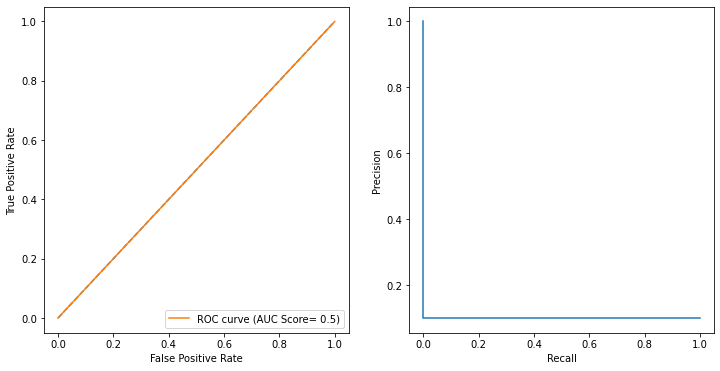

              precision    recall  f1-score   support

           0      0.900     1.000     0.947       450
           1      0.000     0.000     0.000        50

    accuracy                          0.900       500
   macro avg      0.450     0.500     0.474       500
weighted avg      0.810     0.900     0.853       500



C:\Users\danie\anaconda3\envs\ai_coursework_test\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danie\anaconda3\envs\ai_coursework_test\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danie\anaconda3\envs\ai_coursework_test\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

[]

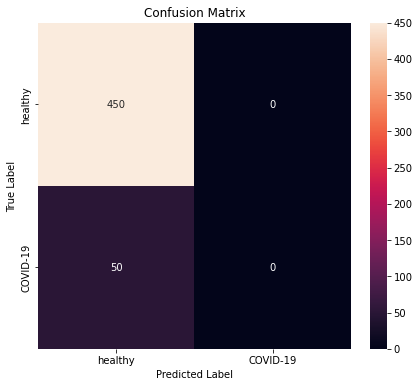

In [35]:
cv_model_1 = rnd_search_cv.best_estimator_.model
y_test_pred = cv_model_1.predict_classes(X_test).reshape(-1)
y_test_probs = cv_model_1.predict_proba(X_test).reshape(-1)

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC Score= {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot() 